In [17]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import urllib
import requests
from bs4 import BeautifulSoup
import re
import networkx as nx
from tqdm import tqdm
from selenium import webdriver
import time
from functools import reduce
import glob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from sklearn.linear_model import Lasso, Ridge,ElasticNet, BayesianRidge, Lars, LassoLars, LinearRegression, MultiTaskElasticNet, MultiTaskLasso, ridge_regression
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from itertools import combinations



This study focuses on the data provided by the flu surveillance program called "Influnet" run by the italian health protection agency. The dataset consists of the week of the year and the associated flu incidence. It covers a time period spanning from 2015 to 2018. This information will be regarded as ground truth. As a matter of fact, the goal is to predict the flu incidence based on Wikipedia page view publicly avaialble data. Hence, a statical model, is developed which provides near real time predictions. This may provide important health related insight and be considerably useful in guiding health policy making. 
In the literature, studies can be found, showing the efficacy of this data in predicting the level of ILI activity in the US, as compared to more traditional data sources.


The most relevant Wikipedia page in order to predict the flu incidence rate is likely to be "Influenza". Let us visualize the corresponding time series.

In [18]:
### Flu_data Functions

def get_week_number(entire_date):
    return entire_date.date().isocalendar()[1]

def get_year(entire_date):
    return entire_date.year

def merge_df(a,b):
    return a.append(b)


### Influnet Functions

def get_year_influnet(date):
    return int(date[:4])

def get_week_influnet(date):
    return int(date[5:])

def match_data(year,week):
    val = gt["Incidence"].loc[(gt["Year"] == year) & (gt["Week"] == week)]
    return float(val)

In [19]:
def get_data(words):
    
    if len(words) > 10:
        return print("No man, you can put just 10 words maximum")

    bs_url = "https://tools.wmflabs.org/pageviews/?project=it.wikipedia.org&platform=all-access&agent=user&range=all-time&pages="+"|".join(words)

    driver = webdriver.Chrome("C:/Users/marti/Downloads/chromedriver_win32/chromedriver.exe")

    driver.get(bs_url)
    
    time.sleep(10)

    first_click = driver.find_elements_by_tag_name("button")
    first_click[6].click()
    
    driver.find_element_by_class_name("download-csv").click()

In [508]:
get_data(["Influenza"]) 

In [20]:
influ = pd.read_csv("pageviews-20150701-20181209.csv")
influ = influ.drop(influ.index[0])

# Convert date to datetime
influ["Date"] = pd.to_datetime(influ["Date"], yearfirst=True)

# Get week number and year
influ["Week"] = influ["Date"].apply(get_week_number)
influ["Year"] = influ["Date"].apply(get_year)

# Group by week number and year
influ = influ.groupby(["Year", "Week"]).sum()
influ = influ.stack()

weeks_of_interest = {2015: [[42,53]], 2016: [[1,16], [42,52]], 2017: [[1,17], [42,52]], 2018: [[1,17]]}

# Merging Dataframes
temp = []
for k,v in weeks_of_interest.items():
    for elem in v:
        temp.append(influ.loc[k,list(range(elem[0],elem[1]+1))])
        
        
influ = reduce(merge_df, temp).unstack()

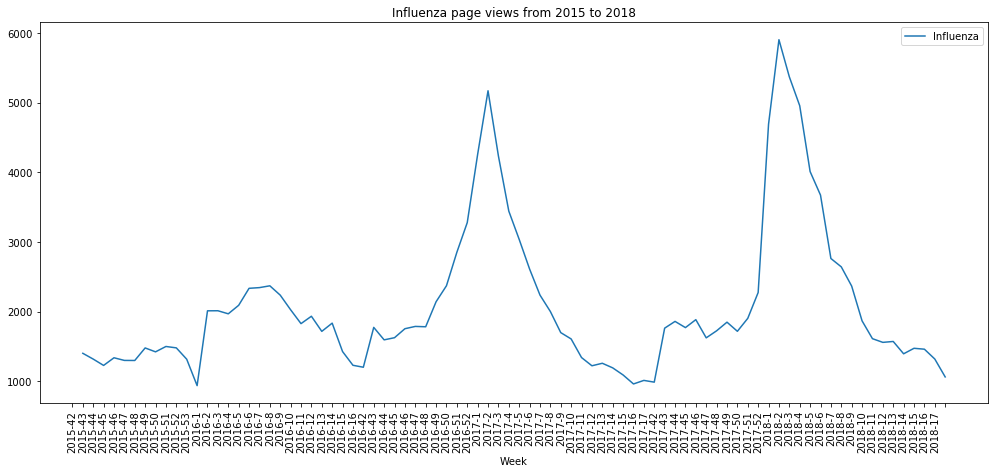

In [21]:
influ.plot(y = "Influenza", label = "Influenza", figsize=(17,7))
plt.xticks(np.arange(-1, len(influ["Influenza"])), [str(x[0] ) + "-" + str(x[1]) for x in influ.index], rotation=90)
plt.title("Influenza page views from 2015 to 2018")
plt.xlabel("Week")
plt.show()

It is higly informative for the purposes of the study to compare the time series above with the one associated with the official Influnet surveillance system. 

In [22]:
# Take the csv files from influnet folder clean the dataframes and return a dataframe containing the ground truth
# the gt dataframe has two columns: the week and the incidence value

files = glob.glob("influnet/*")
temp_gt = []
for file in files:
    print("Adding file " + file + " ...")
    temp = pd.read_csv(file, header=None)
    temp = temp[[0,4]]
    temp = temp.drop(temp.index[0:3])
    temp = temp.replace(to_replace=",", value=".", regex=True)
    temp[4] = pd.to_numeric(temp[4])
    temp = temp.reset_index(drop=True)
    temp.columns=["Date","Influenza"]
    temp_gt.append(temp)

gt = pd.concat(temp_gt, axis=0, ignore_index=True)

Adding file influnet\influnet_1516.csv ...
Adding file influnet\influnet_1617.csv ...
Adding file influnet\influnet_1718.csv ...


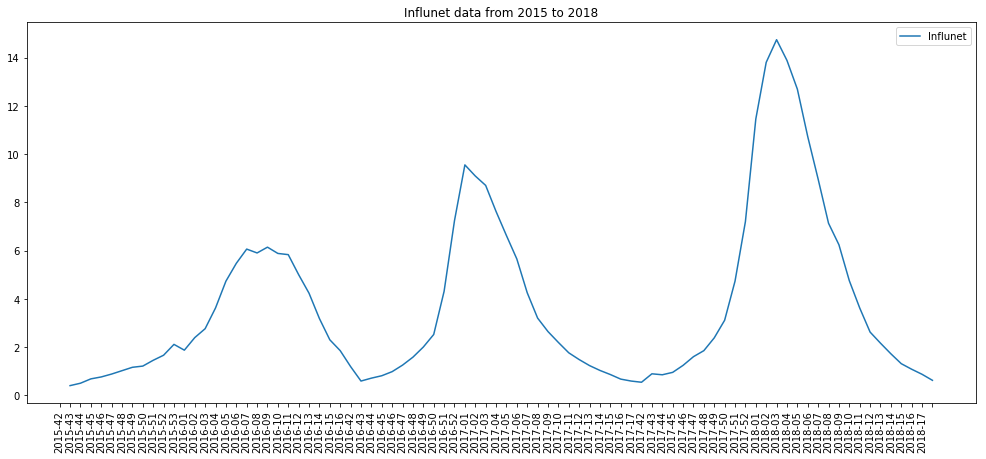

In [23]:
# Plot influnet data

gt.plot(y = "Influenza", label = "Influnet", figsize=(17,7))
plt.xticks(np.arange(-1, len(gt["Influenza"])), gt["Date"], rotation=90)
plt.title("Influnet data from 2015 to 2018")
plt.show()
plt.close()

To facilitate the comparison it might be valuable to overlay the two plots above, although the variables have considerably different scales. 

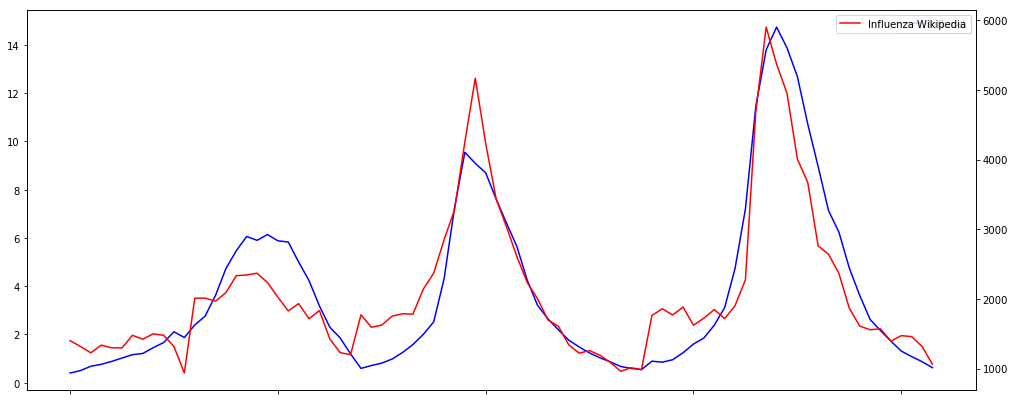

In [24]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

gt.plot(y = "Influenza", label = "Influnet", ax=ax, figsize=(17,7), color = "blue", legend = True)
influ.plot(y = "Influenza", label = "Influenza Wikipedia",  ax=ax2, color = "red", legend = True)

ax.legend(loc='best')
ax2.legend(loc='best')

plt.show()

There is certainly a strong relationship between the taken into account time series. Hence, let us investigate the magnitude of the relationship between them. In particular, the Pearson correlation coefficient, which captures linear dependence as well as the the Spearman correlation coefficient , which measures monotonic relationship, are computed and reported below.


In [25]:
print("Pearson correlation coefficient:" , str(pearsonr(gt["Influenza"], influ["Influenza"])[0]) + "\n" + "Spearman correlation coefficient"
     ,str(spearmanr(gt["Influenza"], influ["Influenza"])[0]))
      
      
      

Pearson correlation coefficient: 0.920579525642
Spearman correlation coefficient 0.83807508522


The correlation measures are both markedly large, particularly the Pearson correlation coefficient, suggesting the existing of a strong linear relationship between the time series under comparison.

## Part 2

In order to identify a set of keywords which might be valuable in order to predict the prevalence of influenza-like Illness, a proper approach involves exploring the portion of Wikipedia Web graph in a neighborhood of the influenza page, in a breadth-first manner. 
Therefore, such network is created. 

In [7]:
url = "https://it.wikipedia.org/wiki/Influenza"
diz = {}

def get_wiki_links(url):
    '''This function takes the out links of a page given in url.
        /wiki is the starting tag of wikipedia pages
        PMID is the tag for counting the citations in a page (we are not interested about it)'''
    page_response = requests.get(url)
    soup = BeautifulSoup(page_response.content, "html.parser")
    links = []
    for link in soup.find_all('a'):
        temp = str(link.get('href'))
        if temp[0:5] == "/wiki" and "PMID" not in temp and ":" not in temp and "secolo" not in temp:
            links.append("https://it.wikipedia.org" + temp)
    return links


def create_g(diz, url):
    '''this function creates the network of neighbours of influenza'''
    # set of all the links 
    visited = set()
    inverse_diz = dict() 
    allLinks = dict()
    G = nx.DiGraph() 
    G.add_node(0)
    diz[0] = url
    inverse_diz[url] = 0
    wiki_links = list(set(get_wiki_links(url)))
    allLinks[0] = wiki_links
    current_label = 0
    visited.add(url) 
    for i in tqdm(range(len(wiki_links))):
        if wiki_links[i] not in  visited: 
            current_label += 1 
            G.add_node( current_label )
            diz[ current_label ] = wiki_links[i]
            inverse_diz[wiki_links[i]] = current_label
            G.add_edge(0 , current_label)
            visited.add(wiki_links[i]) 
          
    for i in tqdm(range(len(wiki_links))):
        links_h1 = list(set(get_wiki_links(wiki_links[i])))
        precedent_label = inverse_diz[wiki_links[i]]
        allLinks[current_label] = links_h1
        for j in range(len(links_h1)):
            if links_h1[j] not in visited: 
                current_label += 1 
                G.add_node( current_label )
                inverse_diz[ links_h1[j] ] = current_label
                diz[ current_label ] = links_h1[j]
                G.add_edge( precedent_label , current_label )
                visited.add( links_h1[j] )

     #add links to already existing nodes 
     #to complete 
    for i in tqdm(range(len(wiki_links))):
        for link in list(set(get_wiki_links(wiki_links[i]))):
            if link in visited and not G.has_edge( inverse_diz[ wiki_links[i] ], inverse_diz[link] ):
                G.add_edge(inverse_diz[ wiki_links[i] ], inverse_diz[link])
        
    return [G , diz, inverse_diz, allLinks] 

In [68]:
G_list = create_g(diz, url)
G = G_list[0] 
diz = G_list[1]
inv_diz = G_list[2]
allLinks = G_list[3]

100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:12<00:00,  3.60it/s]


Although the graph includes nodes having hop distance $2$ from the source (i.e. influenza), only its neighbours are considered, since they are likely to be the most relevant for the purposes of this work. 

In [74]:
G_sub = G.subgraph(list(G.neighbors(0)))

The network built above can be used in order to identify Wikipedia pages higly related with the one of interest: influenza. As a matter of fact, it is possible to define keyword rankings based on link analysis. 

In [76]:
def pPR_ranking(G, n):
    '''this function returns the n pages associated with the highest personalized page
    rank score. 
    Personalization implies that all random jumps are directed to influenza '''
    PersonalizedpageRanking = nx.pagerank(G,personalization={0:1})
    PersonalizedpageRanking = sorted(PersonalizedpageRanking.items(), key=lambda kv: kv[1],
                                    reverse = True)
    topWords = [diz[x[0]] for x in PersonalizedpageRanking[:n]]
    return topWords

In [83]:
def degree_ranking(G, n): 
    '''this functions returns the n pages associated with the higest degree'''
    SortedDegree = sorted(dict(G.degree).items(), key=lambda kv: kv[1],
                                reverse = True)
    topWords = [diz[x[0]] for x in SortedDegree[:n]]
    return topWords
    

In [91]:
degree_ranking(G_sub, 30)

['https://it.wikipedia.org/wiki/Influenza',
 'https://it.wikipedia.org/wiki/Influenzavirus_C',
 'https://it.wikipedia.org/wiki/Pagina_principale',
 'https://it.wikipedia.org/wiki/Asma',
 'https://it.wikipedia.org/wiki/Rinite',
 'https://it.wikipedia.org/wiki/Bronchite',
 'https://it.wikipedia.org/wiki/Faringite',
 'https://it.wikipedia.org/wiki/SARS',
 'https://it.wikipedia.org/wiki/Croup',
 'https://it.wikipedia.org/wiki/Broncopneumopatia_cronica_ostruttiva',
 'https://it.wikipedia.org/wiki/Sarcoidosi',
 'https://it.wikipedia.org/wiki/Sinusite',
 'https://it.wikipedia.org/wiki/Faringite_streptococcica',
 'https://it.wikipedia.org/wiki/Embolia_polmonare',
 'https://it.wikipedia.org/wiki/Bronchiolite',
 'https://it.wikipedia.org/wiki/Pneumotorace',
 'https://it.wikipedia.org/wiki/Edema_polmonare',
 'https://it.wikipedia.org/wiki/Versamento_pleurico',
 'https://it.wikipedia.org/wiki/Pleurite',
 'https://it.wikipedia.org/wiki/Laringite_acuta',
 'https://it.wikipedia.org/wiki/Tonsillite',


However, is not appropriate to simply consider the words above. Indeed, epidemiology studies require integrating data analysis methods and subject matter knowledge. In other words, the chosen words should be biologically meaningful. 
Hence, the words "Vomito" , "Bronchite", "Faringite", "Rinite", "Sinusite" are extacted from the list above. 
It is easy no notice that the output of the link analysis procedure does not include common names for influence symptoms as well as drug names. 
As a consequence, the aforementioned words are combined with: "Tosse", "Raffreddore", "Febbre", "Ibruprofene" and "Flurbiprofene".
The word "Paracetamolo" is also probably remarkably useful in order to predict ILI incidence, but it has a drawback: the number of search associated with this keyword shows large peaks in correspondence of the release of a song called "Paracetamolo" which could bias predictions. 

The code below can be used in order to download and preprocess the required time series data.

In [189]:
# Download data 
get_data(["Vomito" , "Bronchite", "Faringite", "Rinite", "Paracetamolo","Tosse", "Raffreddore", "Febbre", "Ibuprofene", "Flurbiprofene"]) 

In [26]:

# Read data
flu_data = pd.read_csv("pageviews-20150701-20181207.csv")
flu_data = flu_data.drop(flu_data.index[0])

# Convert date to datetime
flu_data["Date"] = pd.to_datetime(flu_data["Date"], yearfirst=True)

# Get week number and year
flu_data["Week"] = flu_data["Date"].apply(get_week_number)
flu_data["Year"] = flu_data["Date"].apply(get_year)

# Group by week number and year
flu_data = flu_data.groupby(["Year", "Week"]).sum()
flu_data = flu_data.stack()

weeks_of_interest = {2015: [[42,53]], 2016: [[1,16], [42,52]], 2017: [[1,17], [42,52]], 2018: [[1,17]]}

# Merging Dataframes
temp = []
for k,v in weeks_of_interest.items():
    for elem in v:
        temp.append(flu_data.loc[k,list(range(elem[0],elem[1]+1))])
        
        
flu_data = reduce(merge_df, temp).unstack()

Let us also add influenza query amount time series. 

In [27]:
get_data(["Antipiretico", "Polmonite", "Tonsillite", "Influenza"]) 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\marti\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-325f6c587284>", line 1, in <module>
    get_data(["Antipiretico", "Polmonite", "Tonsillite", "Influenza"])
  File "<ipython-input-19-4d184b34fd39>", line 14, in get_data
    first_click = driver.find_elements_by_tag_name("button")
  File "C:\Users\marti\Anaconda3\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 546, in find_elements_by_tag_name
    return self.find_elements(by=By.TAG_NAME, value=name)
  File "C:\Users\marti\Anaconda3\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 1007, in find_elements
    'value': value})['value'] or []
  File "C:\Users\marti\Anaconda3\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "C:\Users\marti\Anaconda3\lib\si

WebDriverException: Message: chrome not reachable
  (Session info: chrome=70.0.3538.102)
  (Driver info: chromedriver=2.44.609538 (b655c5a60b0b544917107a59d4153d4bf78e1b90),platform=Windows NT 10.0.17134 x86_64)


In [28]:

# Read data
influ = pd.read_csv("pageviews-20150701-20181208 (1).csv")
influ = influ.drop(influ.index[0])

# Convert date to datetime
influ["Date"] = pd.to_datetime(influ["Date"], yearfirst=True)

# Get week number and year
influ["Week"] = influ["Date"].apply(get_week_number)
influ["Year"] = influ["Date"].apply(get_year)

# Group by week number and year
influ = influ.groupby(["Year", "Week"]).sum()
influ = influ.stack()

weeks_of_interest = {2015: [[42,53]], 2016: [[1,16], [42,52]], 2017: [[1,17], [42,52]], 2018: [[1,17]]}

# Merging Dataframes
temp = []
for k,v in weeks_of_interest.items():
    for elem in v:
        temp.append(influ.loc[k,list(range(elem[0],elem[1]+1))])
        
        
influ = reduce(merge_df, temp).unstack()

In [29]:
flu_data = pd.concat([flu_data, influ], axis=1)
flu_data

Bronchite  Faringite  Febbre  Flurbiprofene  Ibuprofene  \
Year Week                                                            
2015 42       2342.0     1895.0  3330.0          434.0      3828.0   
     43       2442.0     1772.0  3307.0          409.0      3991.0   
     44       2537.0     1661.0  3150.0          533.0      3863.0   
     45       2415.0     1487.0  3305.0          563.0      3865.0   
     46       2444.0     1471.0  3088.0          459.0      3911.0   
     47       2220.0     1454.0  3284.0          589.0      3756.0   
     48       2349.0     1455.0  3503.0          632.0      3724.0   
     49       2398.0     1732.0  3471.0          579.0      3834.0   
     50       2717.0     1770.0  3729.0          465.0      3776.0   
     51       2644.0     1717.0  3701.0          583.0      3713.0   
     52       2614.0     1633.0  3255.0          607.0      3533.0   
     53       2049.0     1264.0  2669.0          504.0      2532.0   
2016 1        4071.0     2285.0  5079.0          810.0      4489.0   
     2        3450.0     2117.0  4654.0          669.0      4805.0   
     3        3527.0     1921.0  4965.0          590.0      4496.0   
     4        3792.0     2107.0  5849.0          538.0      4869.0   
     5        3856.0     2240.0  6436.0          711.0      4988.0   
     6        3761.0     2410.0  6675.0          611.0      4816.0   
     7        3254.0     2425.0  6902.0          542.0      4880.0   
     8        3284.0     2439.0  6958.0          496.0      4733.0   
     9        3259.0     2592.0  6270.0          468.0      4716.0   
     10       2773.0     2441.0  6122.0          505.0      4567.0   
     11       2578.0     2587.0  5967.0          508.0      4597.0   
     12       2590.0     2301.0  5690.0          418.0      4262.0   
     13       2607.0     2104.0  5159.0          467.0      4322.0   
     14       2380.0     2387.0  4268.0          446.0      4145.0   
     15       2151.0     2235.0  3839.0          366.0      3957.0   
     16       1942.0     2239.0  3364.0          413.0      4225.0   
     42       2917.0     1916.0  3466.0          324.0      4197.0   
     43       2613.0     1661.0  3200.0          317.0      4135.0   
...              ...        ...     ...            ...         ...   
2017 16       1626.0     1157.0  3030.0          219.0      4512.0   
     17       1574.0     1138.0  2716.0          205.0      4177.0   
     42       2202.0     1113.0  2782.0          347.0      3010.0   
     43       2099.0     1137.0  4019.0          269.0      2998.0   
     44       2232.0     1155.0  2885.0          337.0      3187.0   
     45       2305.0     1474.0  2841.0          378.0      3154.0   
     46       2524.0     1333.0  3139.0          366.0      3207.0   
     47       2622.0     1826.0  3418.0          359.0      3183.0   
     48       2832.0     1694.0  2940.0          379.0      3144.0   
     49       3043.0     1704.0  2837.0          381.0      3179.0   
     50       3687.0     1873.0  3176.0          398.0      3441.0   
     51       3335.0     1764.0  3284.0          461.0      3526.0   
     52       4704.0     2532.0  6488.0          675.0      5615.0   
2018 1        4788.0     2458.0  5962.0          691.0      5159.0   
     2        4152.0     2195.0  5287.0          597.0      6682.0   
     3        3140.0     2058.0  4643.0          483.0      4440.0   
     4        2976.0     2134.0  4810.0          519.0      4464.0   
     5        2919.0     2165.0  4259.0          482.0      4223.0   
     6        2601.0     2377.0  3704.0          470.0      3729.0   
     7        3307.0     2484.0  3526.0          468.0      3539.0   
     8        4371.0     2487.0  3247.0          454.0      3972.0   
     9        3711.0     2202.0  2922.0          433.0      3513.0   
     10       3521.0     2453.0  2665.0          434.0      3797.0   
     11       2423.0     2302.0  2657.0          456.0      3496.0   
     12       2365.0 

In [30]:
files = glob.glob("influnet/*")
temp_gt = []
for file in files:
    print("Adding file " + file + " ...")
    temp = pd.read_csv(file, header=None)
    temp = temp[[0,4]]
    temp = temp.drop(temp.index[0:3])
    temp = temp.replace(to_replace=",", value=".", regex=True)
    temp[4] = pd.to_numeric(temp[4])
    temp = temp.reset_index(drop=True)
    temp.columns=["Week","Incidence"]
    temp_gt.append(temp)

gt = pd.concat(temp_gt, axis=0, ignore_index=True)

Adding file influnet\influnet_1516.csv ...
Adding file influnet\influnet_1617.csv ...
Adding file influnet\influnet_1718.csv ...


In [31]:
gt["Year"] = gt["Week"].apply(get_year_influnet)
gt["Week"] = gt["Week"].apply(get_week_influnet)
flu_data["GT"] = ["0" for _ in range(flu_data.shape[0])]
flu_data = flu_data.stack()
for year in flu_data.index.levels[0]:
    for week in flu_data.index.levels[1]:
        try:
            flu_data.loc[year,[week],"GT"] = match_data(year,week)
        except:
            pass
flu_data = flu_data.unstack()


Let us investigate the magnitude of the relationship between the selected keywords and the ground truth.

In [33]:
def corr(dataframe,words):
    
    '''Evaluate the Pearson correlation among the list of words and the GT
        Return the dictionary with the correlated words and their value is it is >0.5'''
    
    corr = {}
    for word in words:
            corr[word] = [pearsonr(dataframe["GT"], dataframe[word])[0], spearmanr(dataframe["GT"], dataframe[word])[0]]
    return corr

In [34]:
words = list(flu_data.columns[:-1])
corr_words = corr(flu_data,words)
for word in corr_words: 
    print(word + "\n" + "Pearson Correlation Coefficient: "  + str(corr_words[word][0])
          + "\n" + "Spearman Correlation Coefficient: " +  str(corr_words[word][1]) + "\n\n")

Bronchite
Pearson Correlation Coefficient: 0.697448449458
Spearman Correlation Coefficient: 0.795449943465


Faringite
Pearson Correlation Coefficient: 0.46845501345
Spearman Correlation Coefficient: 0.543978129932


Febbre
Pearson Correlation Coefficient: 0.650294058768
Spearman Correlation Coefficient: 0.672728101136


Flurbiprofene
Pearson Correlation Coefficient: 0.456954552627
Spearman Correlation Coefficient: 0.54296287672


Ibuprofene
Pearson Correlation Coefficient: 0.560280346777
Spearman Correlation Coefficient: 0.490414357006


Paracetamolo
Pearson Correlation Coefficient: 0.770595964032
Spearman Correlation Coefficient: 0.77748247155


Raffreddore
Pearson Correlation Coefficient: 0.545544521493
Spearman Correlation Coefficient: 0.575573158733


Rinite
Pearson Correlation Coefficient: 0.389234246367
Spearman Correlation Coefficient: 0.473702595623


Tosse
Pearson Correlation Coefficient: 0.264604212252
Spearman Correlation Coefficient: 0.314590473495


Vomito
Pearson Correla

Thus influenza exhibits the highest correlation with the ground truth as compared to the other considered words. 

Let us also graphically explore the time series associated with all the relevant terms. 

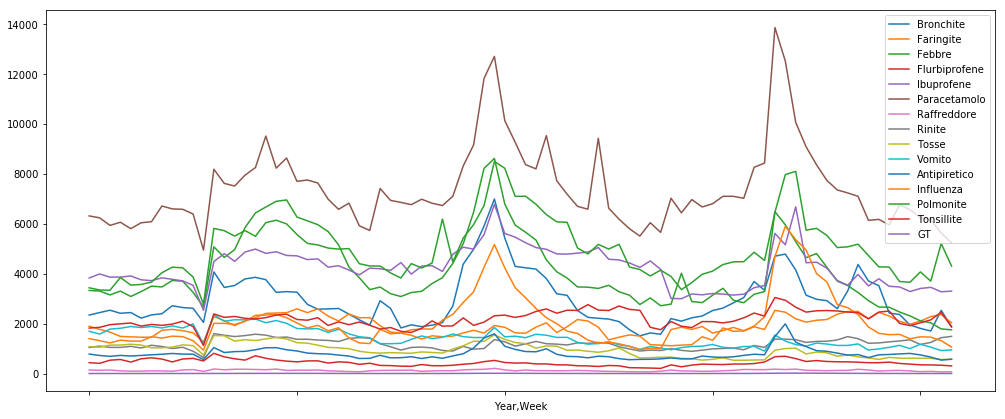

In [35]:
flu_data.plot(figsize=(17,7))
plt.show()

# Part III

Now, the model fitting stage is addressed. This involves selecting the model and the features i.e. the keywords, providing the best performance, according to a given criterion.

In [36]:
models = {}
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["Gradient_Boosting"] = GradientBoostingRegressor(n_estimators=1000)
models["ElasticNet"] = ElasticNet()
models["Bayesian_Ridge"] = BayesianRidge()

The machine learning pipeline can be described as follows. A number of candidate models are trained and a grid search of the parameter space based on cross-validation is carried out. Finally, the cross-validated mean squared error is reported so that the best model is easily identified. 
Clearly, when dealing with time series data, it is more appropriate to use "forward chaining" cross-validation rather than K-fold cross validation. 
Moreover, it might be appropriate to preliminarily scale the data. In this case, we transform the data using statistics which are robust to outliers. Specifically, we subtract the median and divide by the interquartile range. 

In [37]:
def dataset_to_model(dataframe, predictors):
    
    '''Create the datasets to be used in the model.
        shift = True used in point 3.2 for AutoRegressive models'''

    x = dataframe[predictors]
    x_test = np.asarray(x.loc[2018])
    x_train = np.asarray(x.loc[[2015, 2016, 2017]])
    y_train = dataframe.loc[[2015, 2016, 2017]][["GT"]]
    y_train = np.asarray(y_train).reshape(len(x_train), )
    y_test = np.asarray(dataframe.loc[2018][["GT"]]).reshape(len(x_test),)

    # Rescaling
    
    min_max_scaler = preprocessing.RobustScaler()
    X_train = min_max_scaler.fit_transform(x_train)
    X_test = min_max_scaler.transform(x_test)
    X = min_max_scaler.fit_transform(x)
    
    return X_train, X_test, y_train, y_test, X

In [38]:
def model_selection(models, X_train, X_test, y_train, y_test, year_to_be_predicted):
    
    '''Return the best model.
        Apply grid search for parameters of the models given in input.
        Apply cross validation (specifically for Time Series).'''
    
    # Set initial params
    
    min_mse = 100
    max_r2 = 0
    
    # Set different parameters grid for the models

    for name, mod in models.items():
        if name in ["Lasso", "Ridge"]:
            param_search = {'alpha' : [0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2 , 2.5, 3, 3.5]}

        if name == "ElasticNet": 
            param_search = {'alpha' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 0.6,0.7,0.8,1],
                             'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1]
                           }
        if name == "Gradient_Boosting":
            param_search = {'max_depth' : [2, 3, 4, 5],
                            'learning_rate' :[0.01,0.05, 0.1, 0.15, 0.2, 0.3]
                           }
        if name == "Bayesian_Ridge":
            param_search = {'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6],
                            'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

        # Apply Cross-Validation and GridSearch
#        try:
        my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
        gsearch = GridSearchCV(estimator=mod, cv=my_cv,
                            param_grid=param_search, n_jobs=-1)
        a = gsearch.fit(X_train, y_train)
        pred = a.predict(X_test)
#        except:
#         a = mod.fit(X_train, y_train)
#         pred = a.predict(X_test)
        # Evaluate predictions (MSE and R^2)

        mse = mean_squared_error(y_test, pred)

        # Save the best model
        if mse < min_mse:
            min_mse = mse
            best_model = gsearch
            best_name = name

    return [best_model, best_name, min_mse]

The results of the procedure are shown below.

In [39]:
X_train, X_test, y_train, y_test, X = dataset_to_model(flu_data, [word for word in words if word!= "GT"])
best_model, name, min_mse = model_selection(models, X_train, X_test, y_train, y_test, 2018)

print("Model chosen: " + str(name))
print("MSE for 2018: " + str(min_mse))

Model chosen: Ridge
MSE for 2018: 9.94526997917


The Ridge regression model outperforms the other ones. Thus, in what follows, the focus is on it. In order to address the feature selection problem, a possible approach is based on the estimated regression coefficients.

In [19]:
from sklearn.model_selection import cross_val_score
def CVRMSE(train_predictors, y, regressor, avg = True):
    my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
   #compute the Root Mean Squared Errors corresponding to different folds.
    rmses =  np.sqrt(-cross_val_score(regressor, train_predictors, y, scoring="neg_mean_squared_error", cv = my_cv))
    if avg: 
       #return mean
        return rmses.mean()
   #return standard deviation 
    return rmses.std()

The code below is only an auxiliary procedure aimed at selecting the number of words to be retained.

In [118]:
from sklearn.feature_selection import SelectFromModel

ridge = Ridge(alpha=3.5)
ridge.fit(X_train, y_train) 

def printTresholdRMSE(train, y, ridge):
    thresholds = sorted(set(ridge.coef_))
    for thresh in thresholds:
        #select features using threshold
        selection = SelectFromModel(ridge, threshold=thresh, prefit=True)#        select_X_train = selection.transform(train)
        select_X_train = selection.transform(train)
        #train model using the selected features
        selection_model = Ridge(alpha=3.5)
        selection_model.fit(select_X_train, y)
         #avoid error messages 
        if select_X_train.shape[1] <=2: 
             break
        print("Thresh=%.8f, n=%d, rmse: %.8f%%" % (thresh, select_X_train.shape[1], CVRMSE(select_X_train, y, selection_model)))

In [596]:
printTresholdRMSE(X_train, y_train, ridge)

Thresh=-0.43750042, n=14, rmse: 1.91051950%
Thresh=-0.41523439, n=14, rmse: 1.91051950%
Thresh=-0.37290846, n=14, rmse: 1.91051950%
Thresh=-0.11035634, n=14, rmse: 1.91051950%
Thresh=-0.02133882, n=14, rmse: 1.91051950%
Thresh=0.02275587, n=13, rmse: 1.90181472%
Thresh=0.20526665, n=11, rmse: 1.89432230%
Thresh=0.34639931, n=10, rmse: 1.87879389%
Thresh=0.35965136, n=9, rmse: 1.86457687%
Thresh=0.49617562, n=5, rmse: 1.81071660%
Thresh=0.52045815, n=4, rmse: 1.84984231%
Thresh=0.60708274, n=3, rmse: 1.79945535%


In [40]:
def feature_selection(coefs, thresh, complete_data, n_train, scaler):
    '''feature selection for Lasso and Ridge models.
    The procedure simply extracts the optimal subset of features retrieved using the printThresholdRMSE function shown in the auxiliary
    code section. As far as Lasso regression is concerned, this is equivalent to extract features associated with a coefficient different 
    from null. As regards the Ridge linear model, the procedure correspond to select only features having a coefficient larger than 0.008, 
    in absolute value.
    The output allows to fit the model using a smaller set of features, obviously changing the tuning parameter.'''
    
    #list in which each element is a tuple including the name of a feature and the absolute value of its model coefficient. 
    feats_coefs = list(zip(map(lambda x: round(x, 4), abs(coefs)), 
                     complete_data.columns))

    #sort previous list by the value of the cofficient 
    sorted_feats_coef = sorted(feats_coefs, key = lambda x: x[0], reverse = True)
    
    #extract the desired subset of features.
    chosen = [x[1] for x in sorted_feats_coef][:(thresh)]
    
    
    #create the resulting scaled training and test data sets. 
    complete_data_subset = complete_data[chosen]
    model_train = complete_data_subset[:n_train]
    model_test = complete_data_subset[n_train:]
    model_train, model_test = scaling(model_train, model_test, scaler)
    
    return (model_train, model_test, chosen) 

Let us perform feature selection.

In [119]:
ridge_n = 3
   
def scaling(train, test, scaler):
    '''scale the data using the interquantile range and the median.
    Typically, standardization is carried out using the mean and the standard deviation. However, as it is 
    well-known, these satistics are drastically affected by outliers. Thus, here, a robust alternative is considered.'''

    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    return (train, test) 

#complete_data = flu_data
#complete_data.drop("GT", axis=1, inplace=True)

#extract training and test set associated with the selected features. 
ridge_train, ridge_test, chosen = feature_selection(ridge.coef_, ridge_n, complete_data = complete_data, n_train = 67, scaler = preprocessing.RobustScaler()) 

In [120]:
print("The retained terms are : ", " , ".join(chosen))

The retained terms are :  GT1 , Febbre , Influenza


In [601]:
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
param_search = {'alpha' : [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.5]}
gsearch = GridSearchCV(estimator=ridge, cv=my_cv,
                        param_grid=param_search, n_jobs=-1)
a = gsearch.fit(ridge_train, y_train)
pred = a.predict(ridge_test)
mse = mean_squared_error(y_test, pred)
print("MSE:" + str(mse))

ValueError: Found input variables with inconsistent numbers of samples: [17, 16]

In [575]:
pred_train = a.predict(ridge_train)

In [576]:
allpreds = np.asarray(list(pred_train) + list(pred))

In [577]:
# RMSE on the overall dataset 
print("MSE: " + str(mean_squared_error(np.asarray(flu_data["GT"]).reshape(84,), allpreds)))


MSE: 2.00822059253


Let us visualize the predictions. 

In [92]:
def plot_pred(flu_data, allpreds ):
    plot = flu_data.copy()
    plot["Predicted_18"] = allpreds
    plot.GT.plot(label="GT", legend=True)
    plot.Predicted_18.plot(label="Predicted", legend=True)
    plt.title("Model predictions vs influnet")
    plt.show()

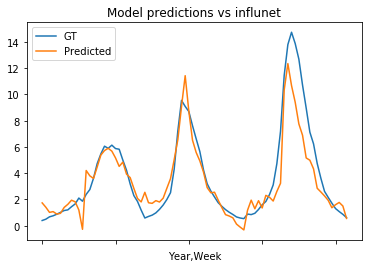

In [578]:
plot_pred(flu_data, allpreds)

Of course a more complex model, including more words, would provide a better fit on the training data.

As usual, when dealing with time series data, it is useful to consider lags of the dependent variable as well as independent ones. Thus, let us evaluate whether more accurate predictions can be obtained after lagged variables are included in the model. 

In [45]:
def get_shift(col):
    flu_serie = pd.Series(np.asarray(flu_data[[col]]).reshape(84,))
    serie = flu_serie.shift(1)
    return serie

def create_shift_dataset(flu_data, cols_list):
    flu_AR1 = flu_data.copy()
    cols_list.append('GT')
    for col in cols_list:
        flu_AR1[col+str(1)] = np.asarray(get_shift(col))
    flu_AR1 = flu_AR1.drop(flu_AR1.index[0])
    return flu_AR1

In [46]:
flu_data_lag = create_shift_dataset(flu_data, cols_list = list(flu_data.columns))

In [47]:
flu_data_lag

Bronchite Faringite Febbre Flurbiprofene Ibuprofene Paracetamolo  \
Year Week                                                                    
2015 43        2442      1772   3307           409       3991         6241   
     44        2537      1661   3150           533       3863         5937   
     45        2415      1487   3305           563       3865         6064   
     46        2444      1471   3088           459       3911         5805   
     47        2220      1454   3284           589       3756         6042   
     48        2349      1455   3503           632       3724         6086   
     49        2398      1732   3471           579       3834         6715   
     50        2717      1770   3729           465       3776         6598   
     51        2644      1717   3701           583       3713         6583   
     52        2614      1633   3255           607       3533         6394   
     53        2049      1264   2669           504       2532         4945   
2016 1         4071      2285   5079           810       4489         8189   
     2         3450      2117   4654           669       4805         7621   
     3         3527      1921   4965           590       4496         7516   
     4         3792      2107   5849           538       4869         7953   
     5         3856      2240   6436           711       4988         8255   
     6         3761      2410   6675           611       4816         9518   
     7         3254      2425   6902           542       4880         8233   
     8         3284      2439   6958           496       4733         8638   
     9         3259      2592   6270           468       4716         7704   
     10        2773      2441   6122           505       4567         7756   
     11        2578      2587   5967           508       4597         7639   
     12        2590      2301   5690           418       4262         6987   
     13        2607      2104   5159           467       4322         6581   
     14        2380      2387   4268           446       4145         6830   
     15        2151      2235   3839           366       3957         5922   
     16        1942      2239   3364           413       4225         5735   
     42        2917      1916   3466           324       4197         7415   
     43        2613      1661   3200           317       4135         6942   
     44        1827      1619   3087           295       4445         6859   
...             ...       ...    ...           ...        ...          ...   
2017 16        1626      1157   3030           219       4512         6045   
     17        1574      1138   2716           205       4177         5658   
     42        2202      1113   2782           347       3010         7025   
     43        2099      1137   4019           269       2998         6442   
     44        2232      1155   2885           337       3187         6972   
     45        2305      1474   2841           378       3154         6677   
     46        2524      1333   3139           366       3207         6805   
     47        2622      1826   3418           359       3183         7104   
     48        2832      1694   2940           379       3144         7103   
     49        3043      1704   2837           381       3179         7024   
     50        3687      1873   3176           398       3441         8267   
     51        3335      1764   3284           461       3526         8434   
     52        4704      2532   6488           675       5615        13867   
2018 1         4788      2458   5962           691       5159        12524   
     2         4152      2195   5287           597       6682        10066   
     3         3140      2058   4643           483       4440         9089   
     4         2976      2134   4810           519       4464         8368   
     5         2919      2165   4259           482       4223         7740   
     6         2601      2377   

The same model selection procedure as before is considered. 

In [48]:
def model_selection(models, X_train, X_test, y_train, y_test, year_to_be_predicted):
    
    '''Return the best model.
        Apply grid search for parameters of the models given in input.
        Apply cross validation (specifically for Time Series).'''
    
    # Set initial params
    
    min_mse = 100
    max_r2 = 0
    
    # Set different parameters grid for the models

    for name, mod in models.items():
        if name in ["Lasso", "Ridge"]:
            param_search = {'alpha' : [1e-9, 1e-8, 1e-6, 1e-4, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1]}

        if name == "ElasticNet": 
            param_search = {'alpha' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 0.6,0.7,0.8,1],
                             'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1]
                           }
        if name == "Gradient_Boosting":
            param_search = {'max_depth' : [2, 3, 4, 5],
                            'learning_rate' :[0.01,0.05, 0.1, 0.15, 0.2, 0.3]
                           }
        if name == "Bayesian_Ridge":
            param_search = {'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6],
                            'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

        # Apply Cross-Validation and GridSearch
#        try:
        my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
        gsearch = GridSearchCV(estimator=mod, cv=my_cv,
                            param_grid=param_search, n_jobs=-1)
        a = gsearch.fit(X_train, y_train)
        pred = a.predict(X_test)
#        except:
#         a = mod.fit(X_train, y_train)
#         pred = a.predict(X_test)
        # Evaluate predictions (MSE and R^2)

        mse = mean_squared_error(y_test, pred)

        # Save the best model
        if mse < min_mse:
            min_mse = mse
            best_model = gsearch
            best_name = name

    return [best_model, best_name, min_mse]

In [50]:
X_train, X_test, y_train, y_test, X = dataset_to_model(flu_data_lag, [x for x in list(flu_data_lag.columns) if x!="GT"])
best_model, name, min_mse = model_selection(models, X_train, X_test, y_train, y_test, 2018)

print("Model chosen: " + str(name))
print("MSE for 2018: " + str(min_mse))

Model chosen: Lasso
MSE for 2018: 0.70041061122


In [121]:
Kernel Ridge (prova)

SyntaxError: invalid syntax (<ipython-input-121-1300701662ed>, line 1)

In [36]:
from sklearn.kernel_ridge import KernelRidge

mod = KernelRidge(kernel = "polynomial")
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
param_search = {"alpha": [0.0 , 0.1, 0.2, 0.5, 0.7, 0.8, 0.9,1 ],
               "gamma" : [0.0 , 0.1, 0.2, 0.5, 0.7, 0.8, 0.9,1 ] + [5,10,15,20,25,30,35,40],
               "degree" : [1,2,3,4],
               "coef0": [0.0 , 0.1, 0.2, 0.5, 0.7, 0.8, 0.9,1 ]}
gsearch = GridSearchCV(estimator=mod, cv=my_cv,
                    param_grid=param_search)
a = gsearch.fit(X_train, y_train)
pred = a.predict(X_test)
mse = mean_squared_error(y_test, pred)
mse

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.2520530663815995e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.035482521587039e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.268282635057411e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5280154045409657e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.740842102174423e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.573503809519371e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2565281792830322e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.238351159700346e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1875100294065533e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.784915955211499e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.9757931607226155e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.183065958552561e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6492839685411384e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5186132755238742e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("S

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.405585494246173e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.223161410902335e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.202432873770177e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0755069944218155e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.591707275852632e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.60426807787956e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.7664934958122e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2650619260044357e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.392393923315687e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Re

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0919306558375687e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.02972096064936e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.401593740241898e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0973921062655366e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.9072559703277114e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3896237975547046e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.626917082000206e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.721075622581191e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.744998121057011e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.675444020022063e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7748312015738953e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.285828966909037e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.484432433455556e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7086724041257195e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.05860355783796e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.742055601966593e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.46153826344652e-20
  ' conditio

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.841509326282692e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.0425032825390606e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.299134443032119e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.9595986640437564e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0645268228147063e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0458707878226066e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.5029650007630255e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.885671106861437e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.395588479558062e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.475158547313449e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.005015757556357e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.3710461896784184e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

2.2359844436351368

In [37]:
a.best_estimator_

KernelRidge(alpha=0.2, coef0=10, degree=2, gamma=0.1, kernel='polynomial',
      kernel_params=None)

In [38]:
pred = a.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, pred)
mse

2.2359844436351368

1

In [329]:
best_model.best_estimator_.fit(X_train, y_train)
pred = best_model.best_estimator_.predict(X_test)
pred_train = best_model.best_estimator_.predict(X_train)
allpreds = np.asarray(list(pred_train) + list(pred))

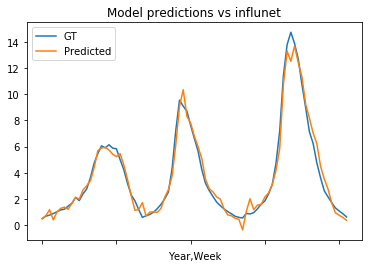

In [333]:
plot_pred(flu_data_lag, allpreds)

We repeat the feature selection procedure on the dataset including the lagged time series.

In [52]:
coefs = best_model.best_estimator_.coef_

In [49]:

complete_data = flu_data_lag.copy()
complete_data.drop("GT", axis = 1, inplace=True)

Only four terms, associated with the largest coefficients estimated by the model above (Lasso) are considered.

In [53]:

n_train = 66
#list in which each element is a tuple including the name of a feature and the absolute value of its model coefficient. 
feats_coefs = list(zip(map(lambda x: round(x, 4), abs(coefs)), 
                 complete_data.columns))

#sort previous list by the value of the cofficient 
sorted_feats_coef = sorted(feats_coefs, key = lambda x: x[0], reverse = True)

#extract the desired subset of features.
chosen = [x[1] for x in sorted_feats_coef][:4]


#create the resulting scaled training and test data sets. 
complete_data_subset = complete_data[chosen]
model_train = complete_data_subset[:n_train]
model_test = complete_data_subset[n_train:]
model_train, model_test = scaling(model_train, model_test, preprocessing.RobustScaler())

In [54]:
best_model, name, min_mse = model_selection(models, model_train, model_test, y_train, y_test, 2018)
print("Model chosen: " + str(name))
print("Test MSE for 2018: " + str(min_mse))

Model chosen: Bayesian_Ridge
Test MSE for 2018: 0.103513196981


In [57]:
pred =  best_model.best_estimator_.predict(model_test)
pred_train = best_model.best_estimator_.predict(model_train)

Correlation between predictions and ground truth in the test set.

In [58]:
corr = [pearsonr(pred , y_test )[0], spearmanr(pred , y_test)[0]]
corr

[0.99840686385424782, 1.0]

Residual range.

In [77]:
print(min(y_test - pred))
print(max(y_test - pred))

-0.5575994068237797
0.6811340248461288


Correlation in the overall dataset.

In [68]:
corr = [pearsonr( (list(pred_train) + list(pred)) , (list(y_train) + list(y_test)) )[0], spearmanr( (list(pred_train) + list(pred)) , (list(y_train) + list(y_test)))[0]]
corr

[0.98200994542326747, 0.97469616528262593]

Try to fit model to the whole data accounting for overfitting via cross-validation.

In [108]:
def model_selection_train(models, X_train, y_train):
    
    '''Return the best model.
        Apply grid search for parameters of the models given in input.
        Apply cross validation (specifically for Time Series).'''
    
    # Set initial params
    
    min_mse = 100
    max_r2 = 0
    
    # Set different parameters grid for the models

    for name, mod in models.items():
        if name in ["Lasso", "Ridge"]:
            param_search = {'alpha' : [1e-9, 1e-8, 1e-6, 1e-4, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1]}

        if name == "ElasticNet": 
            param_search = {'alpha' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 0.6,0.7,0.8,1],
                             'l1_ratio' : [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5,0.6,0.7,0.8,0.9,1]
                           }
        if name == "Gradient_Boosting":
            param_search = {'max_depth' : [2, 3, 4, 5],
                            'learning_rate' :[0.01,0.05, 0.1, 0.15, 0.2, 0.3]
                           }
        if name == "Bayesian_Ridge":
            param_search = {'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6],
                            'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

        # Apply Cross-Validation and GridSearch
#        try:
        my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
        gsearch = GridSearchCV(estimator=mod, cv=my_cv,
                            param_grid=param_search, n_jobs=-1)
        a = gsearch.fit(X_train, y_train)
        pred = a.predict(X_train) 
#        except:
#         a = mod.fit(X_train, y_train)
#         pred = a.predict(X_test)
        # Evaluate predictions (MSE and R^2)

        mse = mean_squared_error(y_train, pred)

        # Save the best model
        if mse < min_mse:
            min_mse = mse
            best_model = gsearch
            best_name = name

    return [best_model, best_name, min_mse]

In [86]:
alldata = np.concatenate((model_train, model_test))

In [88]:
y_alldata = np.array(list(y_train) + list(y_test))

In [109]:
best_model, name, min_mse = model_selection_train(models, alldata, y_alldata)
print("Model chosen: " + str(name))
print("Test MSE for 2018: " + str(min_mse))

Model chosen: Gradient_Boosting
Test MSE for 2018: 0.0390776525353


In [110]:
preds = best_model.best_estimator_.predict(alldata)

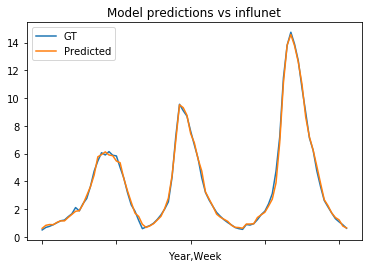

In [111]:
plot_pred(flu_data_lag, preds)

In [112]:
best_model.best_estimator_.fit(model_train, y_train)



GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [113]:
newpreds = best_model.best_estimator_.predict(model_test)

In [114]:
r2 = r2_score(y_test, newpreds)
print("R2 Test", r2)

R2 Test 0.746831077135


In [115]:
mean_squared_error(y_test, newpreds)

6.3770805830184898

In [116]:
train_preds = best_model.best_estimator_.predict(model_train)

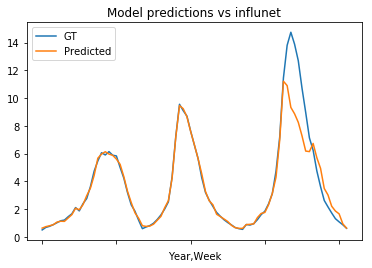

In [117]:
plot_pred(flu_data_lag , list(train_preds) + list(newpreds))

Here, we have a clear example of overfitting.

In [61]:
from sklearn.kernel_ridge import KernelRidge

mod = KernelRidge(kernel = "polynomial")
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
param_search = {"alpha": [0.0 , 0.1, 0.2, 0.5, 0.7, 0.8, 0.9,1 ],
               "gamma" : [0.0 , 0.1, 0.2, 0.5, 0.7, 0.8, 0.9,1 ] + [5,10,15,20,25,30,35,40],
               "degree" : [1,2,3,4],
               "coef0": [0.0 , 0.1, 0.2, 0.5, 0.7, 0.8, 0.9,1 ]}
gsearch = GridSearchCV(estimator=mod, cv=my_cv,
                    param_grid=param_search)
a = gsearch.fit(model_train, y_train)
pred = a.predict(model_test)
mse = mean_squared_error(y_test, pred)
mse

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.681967463631966e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.7049588364419784e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.641896916207066e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.1786171377213645e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0869842624626635e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.2381062159860033e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.082275834868592e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8856689004870097e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.6893411812076674e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.803400635698634e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1426268832791261e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.686637819730292e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.562745718171095e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.885825479609231e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.857389160601528e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5557999467588816e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.332317019604256e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7371667776733804e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.584997821535084e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.528197091386822e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.421879087144272e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.987717701825836e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.3557625459295705e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.841295594544916e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.442561116289332e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.578181591651915e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2789567316054047e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.90885342488408e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.020598722167175e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.788001242314202e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Re

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.347186402275194e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.449585549141642e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.027372268454982e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.832770983339261e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7068410569540257e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.220029444708966e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.4730190144477976e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.9861615295122923e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.611077452004786e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.826490358023186e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6763505424803577e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.534292361814234e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.819292075605465e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.028093512225327e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4703147260728235e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.4033798510034937e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.3892902585143056e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.685558563958164e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.386334259667683e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.760789768871257e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7372392140470696e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2869716672373464e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.405968257827186e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0164762310135563e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.443446168915407e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Us

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.261537097536913e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.06554940619759e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.265073391882122e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Re

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.9410800612297327e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.587386886255065e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.228447913788156e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0918914981319171e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3696282858507115e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.6450547976973164e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3752799550972808e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.6967507159500246e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("S

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.855419624199124e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.516177130398662e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.881516782042403e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.498250679162681e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.6124991757088493e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.409465137427164e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.892813219998358e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.272601596004701e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4717528513334435e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.449667436286487e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.574994798844026e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.707286707307184e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.355921076726816e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6232533137097414e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.872642352835589e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.493945373550315e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.767423051312144e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.940977951915889e-22
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1073296119826077e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.5142410660041227e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5861690957104895e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8194448058075269e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.20727188887238e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.144054674652358e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.407267001643949e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.363541883908137e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4459695342827945e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.1975058513318427e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.1591513335711026e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.422274594999665e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4268968716317027e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0570377828543087e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7076342789294522e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3601285333244069e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5626532671611088e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.667305049414997e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5507642664046696e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.612677745993191e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.238523803098598e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.449607954475261e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.647507014981141e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.306401970599456e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.386184756660401e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.3340662153198195e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.3250870537995958e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linea

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.826306328374162e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.268039121108596e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.312687526888618e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1751031939336388e-22
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2442491857303623e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7930670519782172e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.2918968258418528e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5522405919335022e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.710147434864705e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.14522257080862e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.475044141054313e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6604037914161906e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7738173158987608e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\U

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.315811539737449e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.2811484691609905e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.5824375878272684e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected.

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.2227026322521503e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.4172400107020802e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0762359814176668e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.1916523200620154e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.490452703197439e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.074875676403837e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.321266256445449e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.2258643684210146e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Si

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2998958990372867e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.842946816909516e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.424222863263767e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.982011748813628e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.207057742633948e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.568921496330931e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. R

C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7763268004781826e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.825181375663521e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.962090835033989e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Users\marti\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

0.14914894278267196

Best model (Bayesian Ridge above) Results.

In [695]:
pred = best_model.best_estimator_.predict(model_test)

In [696]:
pred_train = best_model.best_estimator_.predict(model_train) 

In [66]:
print("MSE (overall dataset): " + str(mean_squared_error(np.asarray(flu_data_lag["GT"]).reshape(83,), list(pred_train) + list(pred))))

MSE (overall dataset): 0.444812383791


In [65]:
r2 = r2_score(y_test, pred)
print("R2 Test", r2)

R2 Test 0.994078814483


In [700]:
r2 = r2_score(list(y_train) + list(y_test), list(pred_train) + list(pred))
print("R2 (overall dataset)", r2)

R2 (overall dataset) 0.964221764023


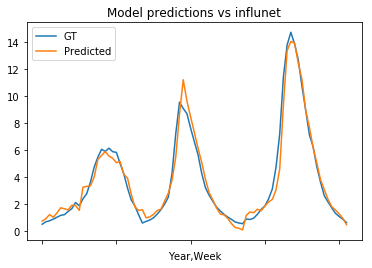

In [660]:
plot_pred(flu_data_lag, np.asarray(list(pred_train) + list(pred)) )

As it is clear from the plot above, introducing lagged features leads to a remarkable improvement. 

A regularized Poisson Regression Model can be fitted as follows. 

In [505]:

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 3 hours 8 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_marti_md3wph
H2O cluster total nodes:,1
H2O cluster free memory:,3.213 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [242]:
flu_data_lag.to_csv("h2oData.csv")
h2o_df = h2o.import_file("h2oData.csv")
glm_model = H2OGeneralizedLinearEstimator(family= "poisson", alpha = 1) 
glm_model.train(y = 10, x = [0,1,2,3,4,5,6,7,8,9,11,12,13],
training_frame = h2o_df) # alpha l1 vs l2 / lambda : strenght h2o weird fuckers


Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


In [664]:
len(flu_data_lag.columns)

30

In [672]:
flu_data_lag.columns

Index(['Bronchite', 'Faringite', 'Febbre', 'Flurbiprofene', 'Ibuprofene',
       'Paracetamolo', 'Raffreddore', 'Rinite', 'Tosse', 'Vomito',
       'Antipiretico', 'Influenza', 'Polmonite', 'Tonsillite', 'GT',
       'Bronchite1', 'Faringite1', 'Febbre1', 'Flurbiprofene1', 'Ibuprofene1',
       'Paracetamolo1', 'Raffreddore1', 'Rinite1', 'Tosse1', 'Vomito1',
       'Antipiretico1', 'Influenza1', 'Polmonite1', 'Tonsillite1', 'GT1'],
      dtype='object')

In [674]:
chosen_data = flu_data_lag(chosen + ["GT"]) 

['GT1', 'Febbre', 'Influenza', 'Flurbiprofene', 'GT']

Parameter space grid search 

In [667]:
from h2o.grid.grid_search import H2OGridSearch

In [668]:
flu_data_lag.to_csv("h2oData.csv")
h2o_df = h2o.import_file("h2oData.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [669]:
alpha_opts = [0.0, 0.25, 0.5, 1.0]
lambda_opts = [1, 0.5, 0.1, 0.01, 0.001, 0.0001,
0.00001, 0]

hyper_parameters = {"alpha":alpha_opts , "lambda":lambda_opts}
grid = H2OGridSearch(H2OGeneralizedLinearEstimator(
family= "poisson"), hyper_params=hyper_parameters)
grid.train(y = 14, x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], training_frame = h2o_df ) 
for m in grid:
    print("Model ID: " + m.model_id + "\n" + " CV metric summary: " , m.cross_validation_metrics_summary)
    print("\n\n")


glm Grid Build progress: |████████████████████████████████████████████████| 100%
Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_26
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_26


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.43100105277
RMSE: 338.259413765608
MAE: 237.1940505945768
RMSLE: 0.06720404929689248
R^2: 0.9198827568742568
Mean Residual Deviance: 22.55019420398398
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661189306706
AIC: 2788.527290994797
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8732539,34.5165474
,2018-12-10 02:33:59,0.001 sec,2,1875.1576674,22.5922631
,2018-12-10 02:33:59,0.002 sec,3,1871.6661890,22.5501971
,2018-12-10 02:33:59,0.002 sec,4,1871.6661189,22.5501963


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_25
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_25


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.43325187176
RMSE: 338.25941709266834
MAE: 237.1940573560419
RMSLE: 0.06720404903947898
R^2: 0.9198827552982184
Mean Residual Deviance: 22.55019420398961
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661189311376
AIC: 2788.527290995271
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8732927,34.5165459
,2018-12-10 02:33:59,0.001 sec,2,1875.1576674,22.5922612
,2018-12-10 02:33:59,0.001 sec,3,1871.6661890,22.5501952
,2018-12-10 02:33:59,0.002 sec,4,1871.6661189,22.5501944


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_21
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_21


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.42865186834
RMSE: 338.25941029314816
MAE: 237.19404536258838
RMSLE: 0.06720404969266518
R^2: 0.9198827585191712
Mean Residual Deviance: 22.55019420399063
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661189312222
AIC: 2788.527290995313
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8732016,34.5165465
,2018-12-10 02:33:59,0.002 sec,2,1875.1576671,22.5922628
,2018-12-10 02:33:59,0.002 sec,3,1871.6661890,22.5501968
,2018-12-10 02:33:59,0.004 sec,4,1871.6661189,22.5501960


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_31
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_31


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.43376299192
RMSE: 338.2594178481834
MAE: 237.1940586886429
RMSLE: 0.06720404896690536
R^2: 0.9198827549403287
Mean Residual Deviance: 22.550194203991964
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.666118931333
AIC: 2788.5272909954138
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8733028,34.5165458
,2018-12-10 02:33:59,0.001 sec,2,1875.1576674,22.5922611
,2018-12-10 02:33:59,0.001 sec,3,1871.6661890,22.5501950
,2018-12-10 02:33:59,0.002 sec,4,1871.6661189,22.5501942


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_32
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_32


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.43376299192
RMSE: 338.2594178481834
MAE: 237.1940586886429
RMSLE: 0.06720404896690536
R^2: 0.9198827549403287
Mean Residual Deviance: 22.550194203991964
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.666118931333
AIC: 2788.5272909954138
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8733028,34.5165458
,2018-12-10 02:33:59,0.001 sec,2,1875.1576674,22.5922611
,2018-12-10 02:33:59,0.002 sec,3,1871.6661890,22.5501950
,2018-12-10 02:33:59,0.002 sec,4,1871.6661189,22.5501942


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_30
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_30


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.43376299192
RMSE: 338.2594178481834
MAE: 237.1940586886429
RMSLE: 0.06720404896690536
R^2: 0.9198827549403287
Mean Residual Deviance: 22.550194203991964
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.666118931333
AIC: 2788.5272909954138
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8733028,34.5165458
,2018-12-10 02:33:59,0.001 sec,2,1875.1576674,22.5922611
,2018-12-10 02:33:59,0.001 sec,3,1871.6661890,22.5501950
,2018-12-10 02:33:59,0.002 sec,4,1871.6661189,22.5501942


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_29
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_29


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.43376299192
RMSE: 338.2594178481834
MAE: 237.1940586886429
RMSLE: 0.06720404896690536
R^2: 0.9198827549403287
Mean Residual Deviance: 22.550194203991964
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.666118931333
AIC: 2788.5272909954138
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.000 sec,1,2864.8733028,34.5165458
,2018-12-10 02:33:59,0.001 sec,2,1875.1576674,22.5922611
,2018-12-10 02:33:59,0.001 sec,3,1871.6661890,22.5501950
,2018-12-10 02:33:59,0.001 sec,4,1871.6661189,22.5501942


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_27
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_27


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.42875031105
RMSE: 338.2594104386618
MAE: 237.19404383317533
RMSLE: 0.0672040495543303
R^2: 0.919882758450241
Mean Residual Deviance: 22.55019420399413
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.666118931513
AIC: 2788.5272909956375
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8732197,34.5165489
,2018-12-10 02:33:59,0.001 sec,2,1875.1576674,22.5922651
,2018-12-10 02:33:59,0.002 sec,3,1871.6661890,22.5501991
,2018-12-10 02:33:59,0.002 sec,4,1871.6661189,22.5501982


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_28
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_28


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.42424878686
RMSE: 338.2594037847091
MAE: 237.19403031027596
RMSLE: 0.06720405006918871
R^2: 0.919882761602238
Mean Residual Deviance: 22.550194204004228
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661189323509
AIC: 2788.527290996448
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8731375,34.5165518
,2018-12-10 02:33:59,0.002 sec,2,1875.1576673,22.5922689
,2018-12-10 02:33:59,0.002 sec,3,1871.6661890,22.5502029
,2018-12-10 02:33:59,0.002 sec,4,1871.6661189,22.5502020


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_22
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_22


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.40625449493
RMSE: 338.25937718634634
MAE: 237.19397804061407
RMSLE: 0.06720405225634868
R^2: 0.9198827742019604
Mean Residual Deviance: 22.55019420407809
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661189384813
AIC: 2788.5272910025833
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8727931,34.5165611
,2018-12-10 02:33:59,0.002 sec,2,1875.1576667,22.5922819
,2018-12-10 02:33:59,0.002 sec,3,1871.6661890,22.5502160
,2018-12-10 02:33:59,0.003 sec,4,1871.6661189,22.5502151


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_17
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_17


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.3826532692
RMSE: 338.25934230006004
MAE: 237.1939254296664
RMSLE: 0.06720405622479357
R^2: 0.919882790727695
Mean Residual Deviance: 22.55019420418505
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661189473593
AIC: 2788.527291011397
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8722911,34.5165525
,2018-12-10 02:33:59,0.001 sec,2,1875.1576637,22.5922788
,2018-12-10 02:33:59,0.002 sec,3,1871.6661890,22.5502129
,2018-12-10 02:33:59,0.002 sec,4,1871.6661189,22.5502120


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_23
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_23


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.38385841751
RMSE: 338.25934408145696
MAE: 237.19391071733668
RMSLE: 0.06720405482009327
R^2: 0.9198827898838421
Mean Residual Deviance: 22.550194204304674
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661189572878
AIC: 2788.5272910214107
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8723722,34.5165756
,2018-12-10 02:33:59,0.003 sec,2,1875.1576663,22.5923010
,2018-12-10 02:33:59,0.003 sec,3,1871.6661891,22.5502351
,2018-12-10 02:33:59,0.004 sec,4,1871.6661190,22.5502343


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_24
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_24


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.33906631953
RMSE: 338.2592778717526
MAE: 237.1937760744867
RMSLE: 0.06720405994870693
R^2: 0.9198828212475656
Mean Residual Deviance: 22.550194205164562
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661190286586
AIC: 2788.527291092718
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8715386,34.5166046
,2018-12-10 02:33:59,0.002 sec,2,1875.1576655,22.5923393
,2018-12-10 02:33:59,0.002 sec,3,1871.6661892,22.5502734
,2018-12-10 02:33:59,0.003 sec,4,1871.6661190,22.5502726


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_18
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_18


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114419.1587211125
RMSE: 338.25901129328764
MAE: 237.19325221578944
RMSLE: 0.06720408187383736
R^2: 0.9198829475264736
Mean Residual Deviance: 22.550194213009238
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661196797668
AIC: 2788.527291743864
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.002 sec,1,2864.8681339,34.5166977
,2018-12-10 02:33:59,0.004 sec,2,1875.1576602,22.5924699
,2018-12-10 02:33:59,0.005 sec,3,1871.6661899,22.5504043
,2018-12-10 02:33:59,0.006 sec,4,1871.6661197,22.5504035


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_13
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_13


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114418.92281010839
RMSE: 338.25866257955374
MAE: 237.19272626599965
RMSLE: 0.06720412156874844
R^2: 0.9198831127129206
Mean Residual Deviance: 22.550194223762944
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661205723242
AIC: 2788.527292636446
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8631890,34.5166122
,2018-12-10 02:33:59,0.002 sec,2,1875.1576313,22.5924383
,2018-12-10 02:33:59,0.003 sec,3,1871.6661908,22.5503732
,2018-12-10 02:33:59,0.003 sec,4,1871.6661206,22.5503724


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_19
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_19


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114418.93484826031
RMSE: 338.2586803738528
MAE: 237.1925790104489
RMSLE: 0.06720410754611392
R^2: 0.9198831042837269
Mean Residual Deviance: 22.550194235508847
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661215472343
AIC: 2788.527293611298
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8639777,34.5168430
,2018-12-10 02:33:59,0.003 sec,2,1875.1576579,22.5926610
,2018-12-10 02:33:59,0.003 sec,3,1871.6661919,22.5505958
,2018-12-10 02:33:59,0.004 sec,4,1871.6661215,22.5505950


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_20
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_20


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114418.48730577753
RMSE: 338.25801883440624
MAE: 237.19123257338515
RMSLE: 0.06720415895392995
R^2: 0.9198834176559364
Mean Residual Deviance: 22.55019432155558
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.666128689113
AIC: 2788.5273007531387
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8557139,34.5171341
,2018-12-10 02:33:59,0.004 sec,2,1875.1576570,22.5930432
,2018-12-10 02:33:59,0.005 sec,3,1871.6661993,22.5509788
,2018-12-10 02:33:59,0.006 sec,4,1871.6661287,22.5509780


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_14
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_14


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114416.68755414584
RMSE: 338.2553585002695
MAE: 237.18599487288893
RMSLE: 0.06720437930022484
R^2: 0.9198846778539446
Mean Residual Deviance: 22.550195105794653
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6661937809563
AIC: 2788.5273658450233
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.8216773,34.5180650
,2018-12-10 02:33:59,0.005 sec,2,1875.1576624,22.5943493
,2018-12-10 02:33:59,0.006 sec,3,1871.6662653,22.5522880
,2018-12-10 02:33:59,0.007 sec,4,1871.6661938,22.5522872


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_9
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_9


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114414.33861902199
RMSE: 338.2518863495398
MAE: 237.1807511099184
RMSLE: 0.06720477726900777
R^2: 0.9198863225938699
Mean Residual Deviance: 22.550196177557208
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6662827372484
AIC: 2788.527454801262
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.7725417,34.5172116
,2018-12-10 02:33:59,0.002 sec,2,1875.1574606,22.5940340
,2018-12-10 02:33:59,0.003 sec,3,1871.6663540,22.5519766
,2018-12-10 02:33:59,0.003 sec,4,1871.6662827,22.5519757


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_15
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_15


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114414.45886129583
RMSE: 338.2520640902223
MAE: 237.17926303428476
RMSLE: 0.06720463919397528
R^2: 0.9198862383994337
Mean Residual Deviance: 22.550197355854632
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6663805359344
AIC: 2788.527552599964
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.7802569,34.5195179
,2018-12-10 02:33:59,0.006 sec,2,1875.1578054,22.5962602
,2018-12-10 02:33:59,0.006 sec,3,1871.6664534,22.5542029
,2018-12-10 02:33:59,0.007 sec,4,1871.6663805,22.5542020


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_16
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_16


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114410.02116930927
RMSE: 338.24550428543654
MAE: 237.1657980206442
RMSLE: 0.06720516546970949
R^2: 0.9198893457007434
Mean Residual Deviance: 22.550205961014786
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6670947642272
AIC: 2788.5282668283035
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.002 sec,1,2864.6976896,34.5224237
,2018-12-10 02:33:59,0.008 sec,2,1875.1584277,22.6000820
,2018-12-10 02:33:59,0.009 sec,3,1871.6671703,22.5580325
,2018-12-10 02:33:59,0.009 sec,4,1871.6670948,22.5580317


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_5
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_5


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114394.2744363839
RMSE: 338.22222640799924
MAE: 237.12788738637002
RMSLE: 0.06720774059292062
R^2: 0.9199003716673925
Mean Residual Deviance: 22.550243089922915
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.670176463602
AIC: 2788.5313485276365
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.3777603,34.5199172
,2018-12-10 02:33:59,0.002 sec,2,1875.1600158,22.6011265
,2018-12-10 02:33:59,0.002 sec,3,1871.6702528,22.5591026
,2018-12-10 02:33:59,0.003 sec,4,1871.6701765,22.5591017


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_10
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_10


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114392.39511115618
RMSE: 338.21944815630604
MAE: 237.11350516299052
RMSLE: 0.06720747768124762
R^2: 0.9199016875833593
Mean Residual Deviance: 22.550284250968527
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6735928303876
AIC: 2788.5347648944744
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2864.3636650,34.5317498
,2018-12-10 02:33:59,0.009 sec,2,1875.1643056,22.6131431
,2018-12-10 02:33:59,0.010 sec,3,1871.6736775,22.5711249
,2018-12-10 02:33:59,0.010 sec,4,1871.6735928,22.5711240


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_1
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114369.89144420848
RMSE: 338.18617867116996
MAE: 237.06261748877125
RMSLE: 0.06721155468125672
R^2: 0.9199174447999465
Mean Residual Deviance: 22.55038753016558
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.6821650037432
AIC: 2788.543337067823
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:58,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:58,0.002 sec,1,2863.9023442,34.5233915
,2018-12-10 02:33:58,0.003 sec,2,1875.1706388,22.6099935
,2018-12-10 02:33:58,0.003 sec,3,1871.6822489,22.5680092
,2018-12-10 02:33:58,0.004 sec,4,1871.6821650,22.5680083


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_11
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_11


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114371.1077508556
RMSE: 338.18797694604046
MAE: 237.0462146836312
RMSLE: 0.06721039424460193
R^2: 0.9199165931339794
Mean Residual Deviance: 22.550509093708182
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.692254777779
AIC: 2788.5534268418796
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.002 sec,1,2863.9633833,34.5462852
,2018-12-10 02:33:59,0.018 sec,2,1876.0894355,22.6431500
,2018-12-10 02:33:59,0.020 sec,3,1871.6923885,22.5902737
,2018-12-10 02:33:59,0.020 sec,4,1871.6922548,22.5902722


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_12
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_12


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114330.50558602999
RMSE: 338.1279426282749
MAE: 236.91150043039016
RMSLE: 0.06721687719897966
R^2: 0.9199450230386058
Mean Residual Deviance: 22.551370021946475
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.7637118215575
AIC: 2788.6248838856436
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2863.1907522,34.5753732
,2018-12-10 02:33:59,0.018 sec,2,1875.3136517,22.6711306
,2018-12-10 02:33:59,0.028 sec,3,1871.7637886,22.6285698
,2018-12-10 02:33:59,0.029 sec,4,1871.7637118,22.6285689


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_6
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_6


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114293.59383073806
RMSE: 338.07335569479307
MAE: 236.79312513908403
RMSLE: 0.06722395628533281
R^2: 0.9199708688940436
Mean Residual Deviance: 22.552430593816677
Null degrees of freedom: 82
Residual degrees of freedom: 53
Null deviance: 22757.599889483026
Residual deviance: 1871.8517392867843
AIC: 2788.712911350849
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.015 sec,1,2862.4641679,34.5927420
,2018-12-10 02:33:59,0.031 sec,2,1875.3565676,22.6968399
,2018-12-10 02:33:59,0.043 sec,3,1871.9206239,22.6556308
,2018-12-10 02:33:59,0.051 sec,4,1871.8517393,22.6548386


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_7
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_7


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114234.77195851094
RMSE: 337.9863487753772
MAE: 236.37872414031654
RMSLE: 0.06724062180234014
R^2: 0.92001205635842
Mean Residual Deviance: 22.558010458049047
Null degrees of freedom: 82
Residual degrees of freedom: 54
Null deviance: 22757.599889483026
Residual deviance: 1872.314868018071
AIC: 2787.176040082135
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2860.7778104,34.6656489
,2018-12-10 02:33:59,0.014 sec,2,1878.0316766,22.8191671
,2018-12-10 02:33:59,0.025 sec,3,1872.3163679,22.7506350
,2018-12-10 02:33:59,0.036 sec,4,1872.3148680,22.7506078


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_2
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_2


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114210.60487099137
RMSE: 337.95059531089953
MAE: 236.33380035750574
RMSLE: 0.06724662673995607
R^2: 0.9200289783131047
Mean Residual Deviance: 22.55896750820146
Null degrees of freedom: 82
Residual degrees of freedom: 54
Null deviance: 22757.599889483026
Residual deviance: 1872.394303180721
AIC: 2787.255475244774
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.003 sec,1,2860.3995181,34.6693820
,2018-12-10 02:33:59,0.020 sec,2,1878.0978593,22.8278329
,2018-12-10 02:33:59,0.037 sec,3,1872.3952496,22.7594536
,2018-12-10 02:33:59,0.052 sec,4,1872.3943032,22.7594349


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_8
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_8


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114042.23389036002
RMSE: 337.70139752503246
MAE: 235.87464629187397
RMSLE: 0.06730666409381302
R^2: 0.9201468727884796
Mean Residual Deviance: 22.576061474382932
Null degrees of freedom: 82
Residual degrees of freedom: 56
Null deviance: 22757.599889483026
Residual deviance: 1873.8131023737833
AIC: 2784.6742744378316
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.001 sec,1,2858.0957959,34.8117598
,2018-12-10 02:33:59,0.015 sec,2,1879.0861611,23.0048617
,2018-12-10 02:33:59,0.026 sec,3,1873.8279465,22.9410566
,2018-12-10 02:33:59,0.039 sec,4,1873.8131024,22.9407253


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_3
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 114022.36179953531
RMSE: 337.67197366606445
MAE: 235.84160731596475
RMSLE: 0.06731393338196559
R^2: 0.9201607873580425
Mean Residual Deviance: 22.5777047526403
Null degrees of freedom: 82
Residual degrees of freedom: 56
Null deviance: 22757.599889483026
Residual deviance: 1873.9494944691448
AIC: 2784.810666533218
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.002 sec,1,2857.8071173,34.8157281
,2018-12-10 02:33:59,0.015 sec,2,1879.2333305,23.0137313
,2018-12-10 02:33:59,0.029 sec,3,1873.9648948,22.9498623
,2018-12-10 02:33:59,0.042 sec,4,1873.9494945,22.9495255


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_4
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_4


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 113749.46530243733
RMSE: 337.2676463914636
MAE: 235.05661967945076
RMSLE: 0.06749542835744818
R^2: 0.9203518712920814
Mean Residual Deviance: 22.638049223294836
Null degrees of freedom: 82
Residual degrees of freedom: 57
Null deviance: 22757.599889483026
Residual deviance: 1878.9580855334714
AIC: 2787.819257597547
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:33:59,0.000 sec,0,22757.5998895,274.1879505
,2018-12-10 02:33:59,0.005 sec,1,2855.1175841,35.1078699
,2018-12-10 02:33:59,0.020 sec,2,1882.5295435,23.3655184
,2018-12-10 02:33:59,0.031 sec,3,1879.0197048,23.3268510
,2018-12-10 02:33:59,0.044 sec,4,1878.9580855,23.3262254


<bound method ModelBase.cross_validation_metrics_summary of >





In [670]:
# print grid search results 
print(grid.sort_by('mse', True).as_data_frame())


[WARNING] in <ipython-input-670-46e4aca85aa9> line 2:
    >>> print(grid.sort_by('mse', True).as_data_frame())
        ^^^^ grid.sort_by() is deprecated; use grid.get_grid() instead
                                                       Model Id  \
0    Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_4   
1    Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_3   
2    Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_8   
3    Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_2   
4    Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_7   
5    Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_6   
6   Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_12   
7    Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_1   
8   Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_11   
9   Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_10   
10   Grid_GLM_h2oData3.hex_model_python_1544297938921_4_model_5   
11  Grid_GLM_h

In [676]:
chosen_data = flu_data_lag[chosen + ["GT"]]

In [682]:
chosen_data[66:].shape

(17, 5)

In [683]:
alpha_opts = [0.0, 0.25, 0.5, 1.0]
lambda_opts = [1, 0.5, 0.1, 0.01, 0.001, 0.0001,
0.00001, 0]
chosen_data[:66].to_csv("h2oData_train.csv")
h2o_df_train = h2o.import_file("h2oData_train.csv")

chosen_data[66:].to_csv("h2oData_test.csv")
h2o_df_test = h2o.import_file("h2oData_test.csv")


hyper_parameters = {"alpha":alpha_opts , "lambda":lambda_opts}
grid = H2OGridSearch(H2OGeneralizedLinearEstimator(
family= "poisson"), hyper_params=hyper_parameters)
grid.train(y = 4, x = [0,1,2,3], training_frame = h2o_df_train, validation_frame = h2o_df_test ) 
for m in grid:
    print("Model ID: " + m.model_id + "\n" + " CV metric summary: " , m.cross_validation_metrics_summary)
    print("\n\n")


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_1
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81320.09744776608
RMSE: 285.1667888232535
MAE: 228.0152536251836
RMSLE: 0.14854387075731074
R^2: 0.8883880511934744
Mean Residual Deviance: 39.03052074641892
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.014369263649
AIC: 3202.242187159145

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291355.1906281607
RMSE: 539.7732770600641
MAE: 302.7455277

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5011.6917430,76.0268693
,2018-12-10 02:47:37,0.001 sec,2,2604.4423446,39.5233087
,2018-12-10 02:47:37,0.002 sec,3,2576.0114238,39.0881329
,2018-12-10 02:47:37,0.002 sec,4,2576.0143693,39.0881075


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_5
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_5


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81334.4403042821
RMSE: 285.19193590331776
MAE: 228.005621816478
RMSLE: 0.1485348361512643
R^2: 0.8883683656026126
Mean Residual Deviance: 39.03045407157776
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.009968724132
AIC: 3202.2377866196475

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291664.7972525406
RMSE: 540.0599941233756
MAE: 302.862503158086
RMSLE: 0.1313959604896279
R^2: 0.8728711984392715
Mean Residual Deviance: 67.90994145266343
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 17333.

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5017.7585106,76.0727750
,2018-12-10 02:47:37,0.000 sec,2,2604.8387051,39.4983133
,2018-12-10 02:47:37,0.001 sec,3,2576.0116754,39.0593308
,2018-12-10 02:47:37,0.001 sec,4,2576.0099687,39.0592697


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_2
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_2


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81311.8104177526
RMSE: 285.15225830729906
MAE: 228.05175647767913
RMSLE: 0.14855306673000007
R^2: 0.8883994251538933
Mean Residual Deviance: 39.030806741320816
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.033244927174
AIC: 3202.2610628226753

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291846.5737612402
RMSE: 540.2282607946757
MAE: 302.9061669950696
RMSLE: 0.13142898853372675
R^2: 0.8727919669724625
Mean Residual Deviance: 67.95361416136673
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5002.5434812,76.0688794
,2018-12-10 02:47:37,0.001 sec,2,2603.7730752,39.6673634
,2018-12-10 02:47:37,0.001 sec,3,2576.0211696,39.2381152
,2018-12-10 02:47:37,0.001 sec,4,2576.0332449,39.2381592


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_9
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_9


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81346.05296945796
RMSE: 285.21229456224
MAE: 227.99792787671504
RMSLE: 0.1485276384966848
R^2: 0.8883524272032279
Mean Residual Deviance: 39.030432688968546
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.008557471924
AIC: 3202.2363753674626

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291914.80983760965
RMSE: 540.2914119598883
MAE: 302.956775930874
RMSLE: 0.13143225562285715
R^2: 0.8727622247111619
Mean Residual Deviance: 67.96602868692877
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 173

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5022.6300318,76.1096905
,2018-12-10 02:47:37,0.001 sec,2,2605.1597545,39.4783343
,2018-12-10 02:47:37,0.001 sec,3,2576.0140247,39.0362893
,2018-12-10 02:47:37,0.001 sec,4,2576.0085575,39.0361994


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_6
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_6


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81330.06920954159
RMSE: 285.1842723740943
MAE: 228.0238749274544
RMSLE: 0.14853933072597336
R^2: 0.8883743649363285
Mean Residual Deviance: 39.030525595069975
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0146892746184
AIC: 3202.2425071701473

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291910.8440725656
RMSE: 540.2877419232882
MAE: 302.94285154800843
RMSLE: 0.13143494715401954
R^2: 0.8727639532809519
Mean Residual Deviance: 67.96656874232633
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance:

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5013.1707478,76.0936765
,2018-12-10 02:47:37,0.000 sec,2,2604.4980440,39.5703292
,2018-12-10 02:47:37,0.001 sec,3,2576.0117965,39.1343216
,2018-12-10 02:47:37,0.001 sec,4,2576.0146893,39.1342955


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_10
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_10


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81345.14229793265
RMSE: 285.2106980776364
MAE: 228.00157877012657
RMSLE: 0.14852852084518345
R^2: 0.888353677101185
Mean Residual Deviance: 39.03043554837589
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0087461928088
AIC: 3202.236564088329

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291964.0766700085
RMSE: 540.3370028695133
MAE: 302.97285030888565
RMSLE: 0.1314400664824427
R^2: 0.8727407506305785
Mean Residual Deviance: 67.97736979789256
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5021.7103017,76.1138543
,2018-12-10 02:47:37,0.001 sec,2,2605.0906570,39.4927356
,2018-12-10 02:47:37,0.001 sec,3,2576.0132880,39.0512874
,2018-12-10 02:47:37,0.002 sec,4,2576.0087462,39.0512046


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_13
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_13


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.68283536854
RMSE: 285.2169048905912
MAE: 227.99619816007018
RMSLE: 0.1485260227195073
R^2: 0.8883488177085447
Mean Residual Deviance: 39.030431807942485
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.008499324204
AIC: 3202.236317219691

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291971.34965420025
RMSE: 540.3437328721416
MAE: 302.97807251853817
RMSLE: 0.13144048036786765
R^2: 0.8727375805333546
Mean Residual Deviance: 67.97871944064093
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.7283527,76.1180200
,2018-12-10 02:47:37,0.001 sec,2,2605.2324782,39.4738412
,2018-12-10 02:47:37,0.001 sec,3,2576.0148174,39.0311050
,2018-12-10 02:47:37,0.001 sec,4,2576.0084993,39.0310086


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_14
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_14


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.59094757149
RMSE: 285.2167438064804
MAE: 227.9965632555269
RMSLE: 0.14852611058135679
R^2: 0.8883489438246762
Mean Residual Deviance: 39.03043183624761
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.008501192342
AIC: 3202.236319087833

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291976.2776398638
RMSE: 540.3482928999256
MAE: 302.97968006393387
RMSLE: 0.13144126176008933
R^2: 0.872735432557605
Mean Residual Deviance: 67.97985390645422
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 1

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.6363242,76.1184359
,2018-12-10 02:47:37,0.001 sec,2,2605.2255466,39.4752812
,2018-12-10 02:47:37,0.001 sec,3,2576.0147266,39.0326048
,2018-12-10 02:47:37,0.002 sec,4,2576.0085012,39.0325091


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_17
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_17


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.94616641375
RMSE: 285.21736652317253
MAE: 227.9960252171729
RMSLE: 0.14852586121661812
R^2: 0.8883484562863125
Mean Residual Deviance: 39.03043179939766
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987602454
AIC: 3202.2363166557566

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.00945342984
RMSE: 540.3489700678904
MAE: 302.9802039029038
RMSLE: 0.13144130402531642
R^2: 0.8727351135798522
Mean Residual Deviance: 67.97998995816103
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null devianc

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.8382299,76.1188534
,2018-12-10 02:47:37,0.000 sec,2,2605.2397605,39.4733919
,2018-12-10 02:47:37,0.000 sec,3,2576.0149021,39.0305866
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304895


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_18
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_18


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.93696943043
RMSE: 285.2173504004103
MAE: 227.99606172679188
RMSLE: 0.1485258699990649
R^2: 0.8883484689091852
Mean Residual Deviance: 39.030431799650636
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.008498776942
AIC: 3202.236316672436

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.5022650558
RMSE: 540.3494260800651
MAE: 302.98036465851766
RMSLE: 0.13144138216760798
R^2: 0.8727348987765848
Mean Residual Deviance: 67.98010340829815
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance:

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.8290270,76.1188950
,2018-12-10 02:47:37,0.001 sec,2,2605.2390671,39.4735359
,2018-12-10 02:47:37,0.001 sec,3,2576.0148928,39.0307365
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0306395


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_21
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_21


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.9725029761
RMSE: 285.2174126924513
MAE: 227.99600792318756
RMSLE: 0.14852584506708189
R^2: 0.8883484201393435
Mean Residual Deviance: 39.03043179934259
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987566106
AIC: 3202.236316652106

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.5754915618
RMSE: 540.3494938385358
MAE: 302.98041705861266
RMSLE: 0.13144138640290431
R^2: 0.8727348668591302
Mean Residual Deviance: 67.9801170243448
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.8492181,76.1189368
,2018-12-10 02:47:37,0.001 sec,2,2605.2404888,39.4733470
,2018-12-10 02:47:37,0.001 sec,3,2576.0149106,39.0305347
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304376


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_32
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_32


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.96764419331
RMSE: 285.2174041747686
MAE: 227.99601612530944
RMSLE: 0.1485258466640145
R^2: 0.8883484268080297
Mean Residual Deviance: 39.03043179933504
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987561127
AIC: 3202.2363166516366

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.6112046668
RMSE: 540.3495268848367
MAE: 302.9804379715604
RMSLE: 0.13144139932236173
R^2: 0.8727348512927531
Mean Residual Deviance: 67.9801271525246
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.8504390,76.1189460
,2018-12-10 02:47:37,0.001 sec,2,2605.2405697,39.4733420
,2018-12-10 02:47:37,0.001 sec,3,2576.0149115,39.0305290
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304318
,2018-12-10 02:47:37,0.001 sec,5,2576.0084988,39.0304318


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_29
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_29


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.96764419331
RMSE: 285.2174041747686
MAE: 227.99601612530944
RMSLE: 0.1485258466640145
R^2: 0.8883484268080297
Mean Residual Deviance: 39.03043179933504
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987561127
AIC: 3202.2363166516366

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.6112046668
RMSE: 540.3495268848367
MAE: 302.9804379715604
RMSLE: 0.13144139932236173
R^2: 0.8727348512927531
Mean Residual Deviance: 67.9801271525246
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.8504390,76.1189460
,2018-12-10 02:47:37,0.000 sec,2,2605.2405697,39.4733420
,2018-12-10 02:47:37,0.000 sec,3,2576.0149115,39.0305290
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304318
,2018-12-10 02:47:37,0.001 sec,5,2576.0084988,39.0304318


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_31
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_31


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.96764419331
RMSE: 285.2174041747686
MAE: 227.99601612530944
RMSLE: 0.1485258466640145
R^2: 0.8883484268080297
Mean Residual Deviance: 39.03043179933504
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987561127
AIC: 3202.2363166516366

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.6112046668
RMSE: 540.3495268848367
MAE: 302.9804379715604
RMSLE: 0.13144139932236173
R^2: 0.8727348512927531
Mean Residual Deviance: 67.9801271525246
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.8504390,76.1189460
,2018-12-10 02:47:37,0.001 sec,2,2605.2405697,39.4733420
,2018-12-10 02:47:37,0.001 sec,3,2576.0149115,39.0305290
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304318
,2018-12-10 02:47:37,0.001 sec,5,2576.0084988,39.0304318


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_30
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_30


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.96764419331
RMSE: 285.2174041747686
MAE: 227.99601612530944
RMSLE: 0.1485258466640145
R^2: 0.8883484268080297
Mean Residual Deviance: 39.03043179933504
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987561127
AIC: 3202.2363166516366

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.6112046668
RMSE: 540.3495268848367
MAE: 302.9804379715604
RMSLE: 0.13144139932236173
R^2: 0.8727348512927531
Mean Residual Deviance: 67.9801271525246
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.8504390,76.1189460
,2018-12-10 02:47:37,0.001 sec,2,2605.2405697,39.4733420
,2018-12-10 02:47:37,0.001 sec,3,2576.0149115,39.0305290
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304318
,2018-12-10 02:47:37,0.001 sec,5,2576.0084988,39.0304318


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_22
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_22


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.97161884976
RMSE: 285.21741114253484
MAE: 227.9960115357062
RMSLE: 0.14852584592402324
R^2: 0.8883484213528081
Mean Residual Deviance: 39.030431799339524
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987564087
AIC: 3202.236316651898

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.624175781
RMSE: 540.3495388873586
MAE: 302.9804328486917
RMSLE: 0.13144139409759187
R^2: 0.872734845638995
Mean Residual Deviance: 67.98012822700514
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.8482978,76.1189409
,2018-12-10 02:47:37,0.000 sec,2,2605.2404195,39.4733614
,2018-12-10 02:47:37,0.000 sec,3,2576.0149096,39.0305497
,2018-12-10 02:47:37,0.000 sec,4,2576.0084988,39.0304526


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_25
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_25


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.97513665188
RMSE: 285.21741730941307
MAE: 227.9960061937852
RMSLE: 0.14852584345213588
R^2: 0.8883484165246197
Mean Residual Deviance: 39.03043179934281
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.008498756625
AIC: 3202.23631665215

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.6320959386
RMSE: 540.3495462160939
MAE: 302.9804383743245
RMSLE: 0.13144139464077398
R^2: 0.8727348421868123
Mean Residual Deviance: 67.98012973110228
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 1

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.8503169,76.1189451
,2018-12-10 02:47:37,0.001 sec,2,2605.2405616,39.4733425
,2018-12-10 02:47:37,0.001 sec,3,2576.0149114,39.0305295
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304324


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_26
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_26


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.97504824593
RMSE: 285.2174171544331
MAE: 227.99600655502627
RMSLE: 0.14852584353782172
R^2: 0.888348416645957
Mean Residual Deviance: 39.030431799339915
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987564346
AIC: 3202.2363166519094

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.63696436887
RMSE: 540.3495507209836
MAE: 302.9804399533475
RMSLE: 0.1314413954102455
R^2: 0.8727348400647952
Mean Residual Deviance: 67.98013085137053
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.8501023,76.1189437
,2018-12-10 02:47:37,0.000 sec,2,2605.2405515,39.4733439
,2018-12-10 02:47:37,0.001 sec,3,2576.0149113,39.0305310
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304339


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_27
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_27


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.974959827
RMSE: 285.21741699943044
MAE: 227.99600691630613
RMSLE: 0.14852584362352364
R^2: 0.8883484167673121
Mean Residual Deviance: 39.03043179934302
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987566393
AIC: 3202.236316652152

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.6418328366
RMSE: 540.349555225908
MAE: 302.98044153234736
RMSLE: 0.13144139617971398
R^2: 0.8727348379427616
Mean Residual Deviance: 67.98013197164525
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.8498877,76.1189422
,2018-12-10 02:47:37,0.001 sec,2,2605.2405413,39.4733452
,2018-12-10 02:47:37,0.001 sec,3,2576.0149112,39.0305325
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304354


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_28
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_28


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.97478300097
RMSE: 285.2174166894458
MAE: 227.99600763879872
RMSLE: 0.14852584379491496
R^2: 0.8883484170100061
Mean Residual Deviance: 39.030431799343205
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084987566515
AIC: 3202.2363166521664

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.6515697406
RMSE: 540.3495642357275
MAE: 302.98044469038564
RMSLE: 0.13144139771866298
R^2: 0.8727348336987084
Mean Residual Deviance: 67.98013421219156
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null devian

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.8494585,76.1189394
,2018-12-10 02:47:37,0.001 sec,2,2605.2405210,39.4733480
,2018-12-10 02:47:37,0.001 sec,3,2576.0149111,39.0305355
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304384


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_23
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_23


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.97073473429
RMSE: 285.2174095926374
MAE: 227.9960151482279
RMSLE: 0.1485258467809653
R^2: 0.8883484225662579
Mean Residual Deviance: 39.030431799339226
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.008498756389
AIC: 3202.2363166519035

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.67286001553
RMSE: 540.3495839361917
MAE: 302.9804486387665
RMSLE: 0.1314414017922839
R^2: 0.8727348244188531
Mean Residual Deviance: 67.98013942967009
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.8473775,76.1189451
,2018-12-10 02:47:37,0.000 sec,2,2605.2403501,39.4733758
,2018-12-10 02:47:37,0.000 sec,3,2576.0149087,39.0305647
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304676


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_24
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_24


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.96882387834
RMSE: 285.2174062428139
MAE: 227.99602252702084
RMSLE: 0.14852584857992768
R^2: 0.8883484251889103
Mean Residual Deviance: 39.03043179935081
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.008498757153
AIC: 3202.23631665268

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.7726167462
RMSE: 540.3496762437692
MAE: 302.98048136088255
RMSLE: 0.13144141765994072
R^2: 0.8727347809375905
Mean Residual Deviance: 67.9801624045461
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 1

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.8455369,76.1189534
,2018-12-10 02:47:37,0.000 sec,2,2605.2402114,39.4734046
,2018-12-10 02:47:37,0.000 sec,3,2576.0149069,39.0305947
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0304976


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_19
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_19


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.9277731092
RMSE: 285.2173342788078
MAE: 227.9960982364095
RMSLE: 0.1485258787818683
R^2: 0.8883484815311491
Mean Residual Deviance: 39.03043180013094
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.008498808642
AIC: 3202.236316704137

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291977.9950770048
RMSE: 540.3498820921541
MAE: 302.9805254139529
RMSLE: 0.131441460310001
R^2: 0.8727346839731768
Mean Residual Deviance: 67.98021685856398
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 17333

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.8198239,76.1189366
,2018-12-10 02:47:37,0.001 sec,2,2605.2383737,39.4736799
,2018-12-10 02:47:37,0.001 sec,3,2576.0148836,39.0308865
,2018-12-10 02:47:37,0.001 sec,4,2576.0084988,39.0307896


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_20
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_20


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.90938249246
RMSE: 285.2173020391513
MAE: 227.99617125570202
RMSLE: 0.14852589634845462
R^2: 0.8883485067722966
Mean Residual Deviance: 39.03043180175938
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0084989161187
AIC: 3202.236316811619

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291978.9807012113
RMSE: 540.3507941154628
MAE: 302.98084692400266
RMSLE: 0.13144161659498077
R^2: 0.8727342543662261
Mean Residual Deviance: 67.98044375932488
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.8014176,76.1190198
,2018-12-10 02:47:37,0.000 sec,2,2605.2369871,39.4739679
,2018-12-10 02:47:37,0.001 sec,3,2576.0148651,39.0311865
,2018-12-10 02:47:37,0.001 sec,4,2576.0084989,39.0310897


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_15
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_15


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.49912680284
RMSE: 285.2165828397831
MAE: 227.99692835221828
RMSLE: 0.14852619847686457
R^2: 0.888349069848811
Mean Residual Deviance: 39.03043188694207
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0085045381766
AIC: 3202.2363224336837

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291981.2056436369
RMSE: 540.3528529059848
MAE: 302.9812875848852
RMSLE: 0.13144204316035854
R^2: 0.8727332845739619
Mean Residual Deviance: 67.98098838184472
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance:

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5023.5443100,76.1188520
,2018-12-10 02:47:37,0.001 sec,2,2605.2186169,39.4767213
,2018-12-10 02:47:37,0.001 sec,3,2576.0146373,39.0341046
,2018-12-10 02:47:37,0.001 sec,4,2576.0085045,39.0340096


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_16
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_16


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81348.31568639983
RMSE: 285.21626125871546
MAE: 227.99765854918564
RMSLE: 0.1485263743689053
R^2: 0.8883493216210238
Mean Residual Deviance: 39.03043205550742
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0085156634896
AIC: 3202.236333559022

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 291991.0617075627
RMSE: 540.3619728548288
MAE: 302.98450255452394
RMSLE: 0.13144360598543633
R^2: 0.8727289885821015
Mean Residual Deviance: 67.98325736184681
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5023.3602853,76.1196842
,2018-12-10 02:47:37,0.000 sec,2,2605.2047625,39.4796015
,2018-12-10 02:47:37,0.001 sec,3,2576.0144631,39.0371042
,2018-12-10 02:47:37,0.001 sec,4,2576.0085157,39.0370106


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_11
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_11


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81344.23833113453
RMSE: 285.2091133381515
MAE: 228.00522978409714
RMSLE: 0.14852940656048053
R^2: 0.8883549177968943
Mean Residual Deviance: 39.030440646993036
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.00908270154
AIC: 3202.236900597052

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 292013.34540579794
RMSE: 540.3825916938831
MAE: 302.98892228472647
RMSLE: 0.13144787816462328
R^2: 0.8727192757203586
Mean Residual Deviance: 67.98871188838544
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,5020.7909249,76.1180208
,2018-12-10 02:47:37,0.001 sec,2,2605.0217292,39.5071372
,2018-12-10 02:47:37,0.001 sec,3,2576.0126995,39.0662856
,2018-12-10 02:47:37,0.001 sec,4,2576.0090827,39.0662097


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_12
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_12


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81342.4505150741
RMSE: 285.20597910119994
MAE: 228.01253217427953
RMSLE: 0.14853118809301952
R^2: 0.8883573715769669
Mean Residual Deviance: 39.03045756325983
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.010199175149
AIC: 3202.2380170706656

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 292111.8886106885
RMSE: 540.4737631103739
MAE: 303.0210590442684
RMSLE: 0.13146350399921655
R^2: 0.8726763234009229
Mean Residual Deviance: 68.01139901299177
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance:

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5018.9528958,76.1263568
,2018-12-10 02:47:37,0.001 sec,2,2604.8843701,39.5359408
,2018-12-10 02:47:37,0.001 sec,3,2576.0119677,39.0962819
,2018-12-10 02:47:37,0.001 sec,4,2576.0101992,39.0962201


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_7
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_7


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81325.86575088602
RMSE: 285.1769025550387
MAE: 228.0421310610321
RMSLE: 0.1485439094824561
R^2: 0.8883801341892807
Mean Residual Deviance: 39.03065312265503
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.023106095232
AIC: 3202.2509239907577

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 292156.9390065129
RMSE: 540.51543826843
MAE: 303.0231401447595
RMSLE: 0.1314739544798993
R^2: 0.872656687151074
Mean Residual Deviance: 68.02322062466862
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 17333.8

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,5008.5897569,76.1146144
,2018-12-10 02:47:37,0.000 sec,2,2604.1615476,39.6423493
,2018-12-10 02:47:37,0.000 sec,3,2576.0156266,39.2093126
,2018-12-10 02:47:37,0.001 sec,4,2576.0231061,39.2093214


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_3
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81333.38676070243
RMSE: 285.19008881919865
MAE: 228.0431934179331
RMSLE: 0.14854915867749754
R^2: 0.8883698115926663
Mean Residual Deviance: 39.03099634506599
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.045758774355
AIC: 3202.273576669869

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 292327.8128672169
RMSE: 540.6734808248107
MAE: 303.032356445674
RMSLE: 0.1314700384718746
R^2: 0.8725822078538329
Mean Residual Deviance: 68.0546620015018
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 17333

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.000 sec,1,4993.4223074,76.1110353
,2018-12-10 02:47:37,0.000 sec,2,2603.1204681,39.8114345
,2018-12-10 02:47:37,0.001 sec,3,2576.0457588,39.3880978


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_8
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_8


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81317.96220075832
RMSE: 285.1630449422897
MAE: 228.07865248378982
RMSLE: 0.1485533197142658
R^2: 0.8883909818230137
Mean Residual Deviance: 39.03107636610772
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.0510401631095
AIC: 3202.27885805859

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 292649.2787305061
RMSE: 540.9706819509779
MAE: 303.1835407695289
RMSLE: 0.13155203186314685
R^2: 0.8724420895730955
Mean Residual Deviance: 68.13659940315456
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance: 173

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,4999.4481151,76.1566000
,2018-12-10 02:47:37,0.001 sec,2,2603.5010596,39.7864017
,2018-12-10 02:47:37,0.001 sec,3,2576.0344253,39.3592949
,2018-12-10 02:47:37,0.001 sec,4,2576.0510402,39.3593732


<bound method ModelBase.cross_validation_metrics_summary of >



Model ID: Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_4
 CV metric summary:  Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_4


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 81318.84447473238
RMSE: 285.16459190217216
MAE: 228.11657578265437
RMSLE: 0.14856903625674278
R^2: 0.888389770900736
Mean Residual Deviance: 39.03241757491073
Null degrees of freedom: 65
Residual degrees of freedom: 61
Null deviance: 20979.07397290398
Residual deviance: 2576.1395599441084
AIC: 3202.3673778396314

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 293313.9091382992
RMSE: 541.5846278637339
MAE: 303.35332786873926
RMSLE: 0.13162687452072025
R^2: 0.8721523951429844
Mean Residual Deviance: 68.28193255853635
Null degrees of freedom: 16
Residual degrees of freedom: 12
Null deviance:

,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-12-10 02:47:37,0.000 sec,0,20979.0739729,317.8647572
,2018-12-10 02:47:37,0.001 sec,1,4975.2605202,76.1957731
,2018-12-10 02:47:37,0.001 sec,2,2601.8652977,40.0996259
,2018-12-10 02:47:37,0.001 sec,3,2576.1395599,39.6880648


<bound method ModelBase.cross_validation_metrics_summary of >





In [684]:
print(grid.sort_by('mse', True).as_data_frame())


[WARNING] in <ipython-input-684-f7b20881a0e3> line 1:
    >>> print(grid.sort_by('mse', True).as_data_frame())
        ^^^^ grid.sort_by() is deprecated; use grid.get_grid() instead
                                                            Model Id  \
0    Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_2   
1    Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_8   
2    Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_4   
3    Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_1   
4    Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_7   
5    Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_6   
6    Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_3   
7    Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_5   
8   Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_12   
9   Grid_GLM_h2oData_train.hex_model_python_1544297938921_6_model_11   
10  Grid_GLM_h2oData_train